Imports

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Download the Dataset

In [3]:
# !wget {"https://f002.backblazeb2.com/file/deepsig-datasets/2016.10/RML2016.10b.tar.bz2?Authorization=3_20220530112933_8611825267690cd8393e2cef_4f240ffd281722d46b3f0eb22f5d989d2436eb57_002_20220530122933_0027_dnld"}

In [4]:
# os.rename("/content/RML2016.10b.tar.bz2?Authorization=3_20220530112933_8611825267690cd8393e2cef_4f240ffd281722d46b3f0eb22f5d989d2436eb57_002_20220530122933_0027_dnld", "RML2016.10b.tar.bz2")
# !tar xjvf RML2016.10b.tar.bz2

In [5]:
Data = pickle.load(open("/content/RML2016.10b.dat",'rb'), encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Data.keys())))), [1,0])
print(f"Mods: {mods}")
print(f"SNRs: {snrs}")

Mods: [b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [6]:
X = []     
label = []
for snr in snrs:
  x = []
  y = []
  for mod in mods:
    x.append(Data[(mod,snr)])
    y.append([mod] * Data[(mod,snr)].shape[0])
  y = np.array(y)
  label.append(y.reshape((y.shape[0] * y.shape[1])))
  X.append(np.vstack(x))
label = np.array(label)
X = np.array(X)
print(label.shape)        
print(X.shape)

(20, 60000)
(20, 60000, 2, 128)


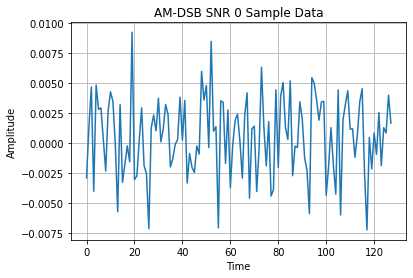

In [7]:
plt.plot(Data[b'AM-DSB',0][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("AM-DSB SNR 0 Sample Data")
plt.grid(b=True, axis='both')

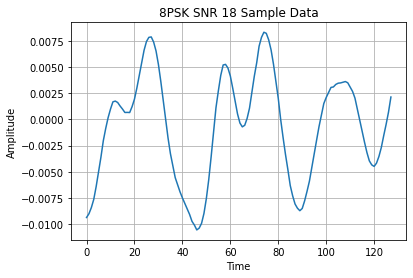

In [ ]:
plt.plot(Data[b'8PSK',18][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("8PSK SNR 18 Sample Data")
plt.grid(b=True, axis='both')

# Raw time series and Models




In [8]:
def encoding(label):
  encoded = []
  for y in label:
    enc = OneHotEncoder(sparse = False).fit_transform(y.reshape(-1,1))
    encoded.append(enc)

  return np.array(encoded)

In [9]:
label_enc = encoding(label)

In [10]:
print(label_enc.shape)

(20, 60000, 10)


In [11]:
def split(data, y):
  feat_train = []
  lab_train = []
  feat_test = []
  lab_test = []
  feat_val = []
  lab_val = []
  len = data.shape[0]
  for i in range(len):
    d = data[0]
    yy = y[0]
    data = data[1:]
    X_train_val,X_test, y_train_val, y_test = train_test_split(d, yy, test_size = 0.3, stratify = yy)
    X_train, X_val,  y_train,y_val = train_test_split (X_train_val, y_train_val, test_size = 0.05, stratify = y_train_val)
    feat_train.append(X_train)
    feat_test.append(X_test)
    feat_val.append(X_val)
    lab_train.append(y_train)
    lab_test.append(y_test)
    lab_val.append(y_val)

  return np.array(feat_train), np.array(feat_val), np.array(feat_test), np.array(lab_train), np.array(lab_val), np.array(lab_test)



In [ ]:
X  = X.reshape((20, 60000, 2, 128, 1))

In [ ]:
feat_train, feat_val, feat_test, lab_train, lab_val, lab_test = split(X, label_enc)

In [ ]:
print(feat_train.shape, lab_train.shape)

(20, 39900, 2, 128, 1) (20, 39900, 10)


##  CNN

In [12]:
def plot_snr_acc(snrs, acc):
  plt.plot(snrs, acc, label = "SNR vs ACC")
  plt.legend()
  plt.show()

In [13]:
def plot_loss_acc(histories):
  for i,h in enumerate(histories):
    pd.DataFrame(h.history).plot(figsize=(8,5))
    plt.title('SNR : ' + str(snrs[i]))
    plt.show()

In [14]:
def confusion_matrixf(y_preds, lab_test):
  for i, y_pred in enumerate(y_preds):
    y_test = np.argmax(lab_test[i], axis=1)
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, xticklabels=mods, yticklabels=mods, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title('SNR : ' + str(snrs[i]))
    plt.show()

In [15]:
def create_model(lr):
  model=Sequential()
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, 3, strides=2, activation='relu', padding='same'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, activation='relu' ))
  model.add(Dense(10,  activation='softmax'))
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
  return model


In [16]:
num_epochs = 20
num_batch_size = 32

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)

In [18]:
def train_models(num_models, feat_train, feat_val, lab_train, lab_val, num_epochs, num_batch_size, lr):
  models = []
  histories = []
  for i in range(num_models):
    checkpointer = ModelCheckpoint(filepath='saved_models/classification' + str(i) + '.hdf5', verbose=1, save_best_only=True)
    model = create_model(lr=lr)
    print(f'\n********************************************************* SNR {snrs[i]} *********************************************************\n')
    with tf.device('/device:GPU:0'):
      history = model.fit(feat_train[i], lab_train[i], batch_size=num_batch_size, epochs=num_epochs, validation_data=(feat_val[i], lab_val[i]), callbacks=[es, checkpointer], verbose=1)
    models.append(model)
    histories.append(history)

  return models, histories

In [19]:
def test_models(models, feat_test, lab_test):
  acc = []
  y_preds = []
  for i, mod in enumerate(models):
    y_pred = np.argmax(mod.predict(feat_test[i]), axis=1)
    test_acc = sum(y_pred == np.argmax(lab_test[i], axis=1)) / len(lab_test[i])
    acc.append(test_acc)
    y_preds.append(y_pred)
    print(f'Test set accuracy mod {i+1} of SNR {snrs[i]}: {test_acc.mean():.0%}')
  return acc, np.array(y_preds)

In [ ]:
models, histories = train_models(len(snrs), feat_train, feat_val, lab_train, lab_val, num_epochs, num_batch_size, 1e-5)


********************************************************* SNR -20 *********************************************************

Epoch 1/20
1244/1247 [============================>.] - ETA: 0s - loss: 2.3026 - accuracy: 0.0971
Epoch 1: val_loss improved from inf to 2.30259, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 7s 5ms/step - loss: 2.3026 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.0929
Epoch 2/20
1239/1247 [============================>.] - ETA: 0s - loss: 2.3026 - accuracy: 0.0990
Epoch 2: val_loss improved from 2.30259 to 2.30258, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 7s 5ms/step - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3026 - val_accuracy: 0.0976
Epoch 3/20
1246/1247 [============================>.] - ETA: 0s - loss: 2.3026 - accuracy: 0.1010
Epoch 3: val_loss improved from 2.30258 to 2.30258, saving model to saved_models/classification0.hdf5
1247/1247 [=

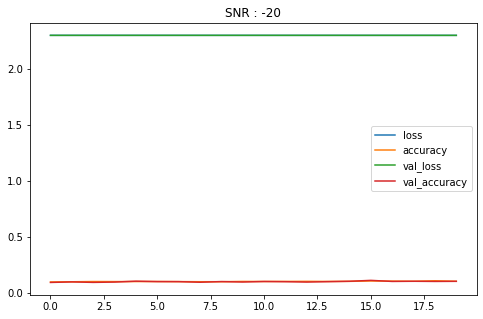

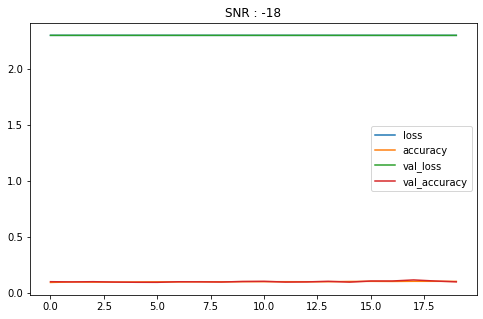

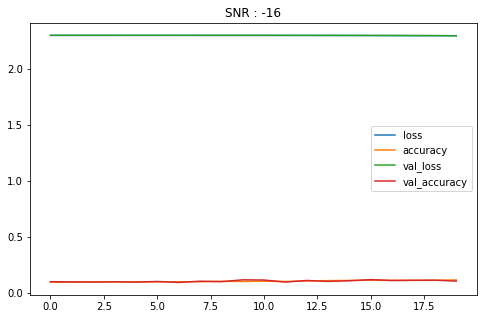

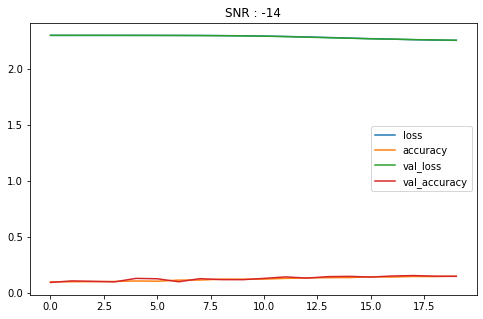

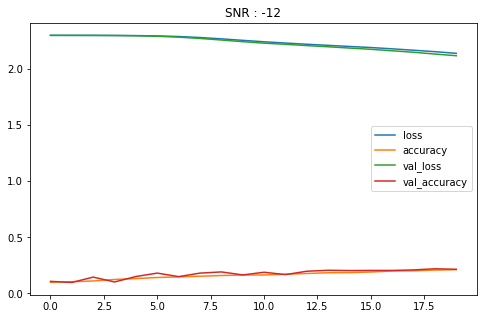

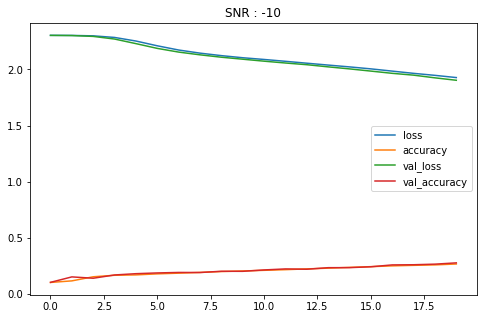

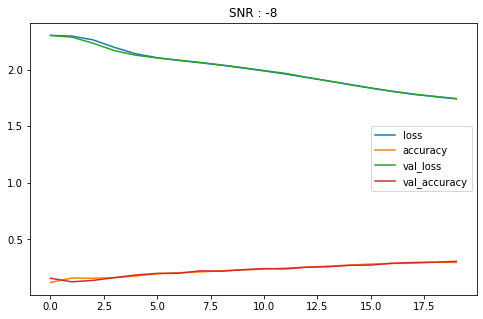

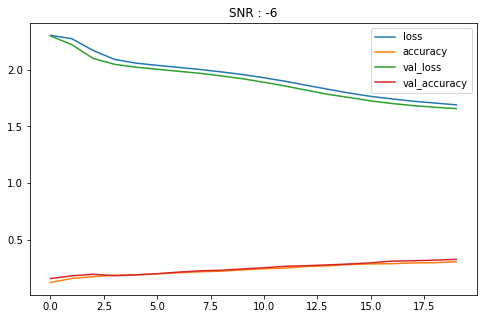

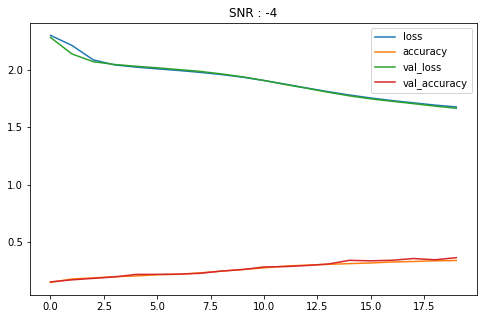

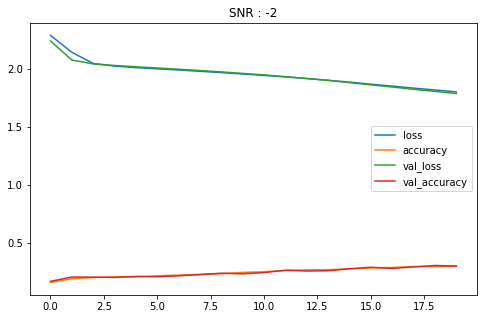

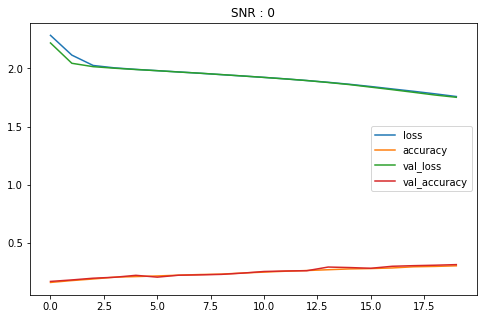

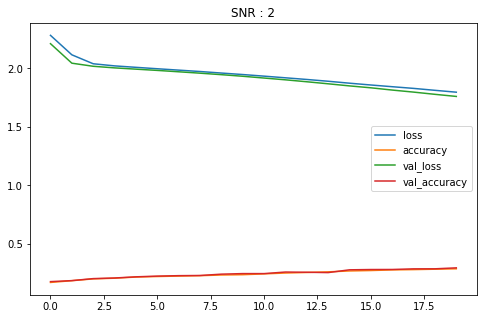

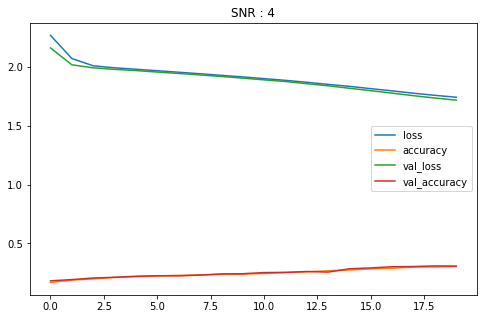

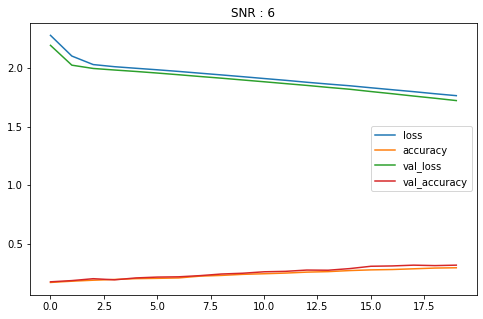

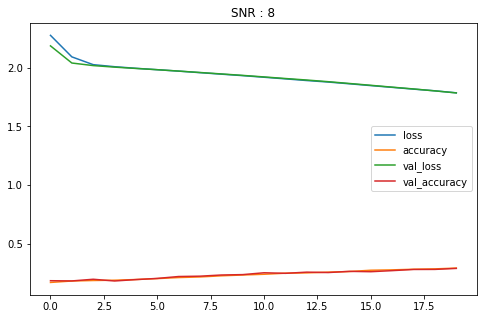

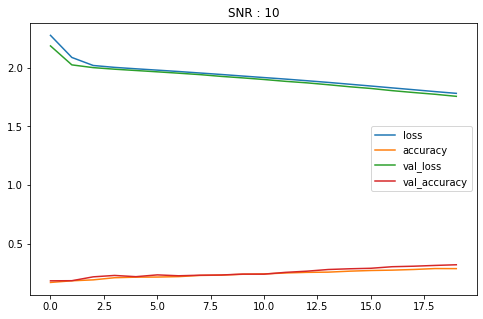

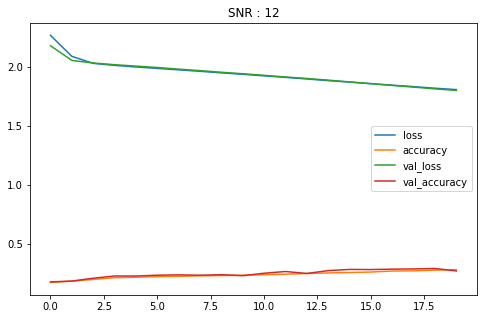

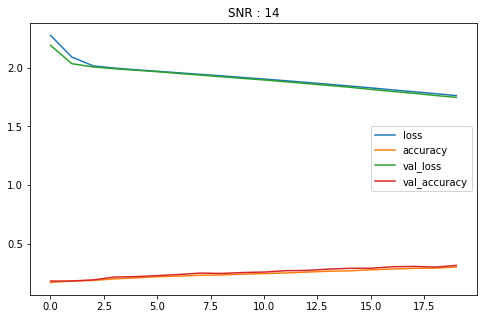

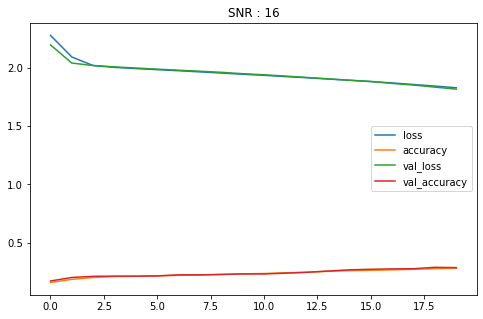

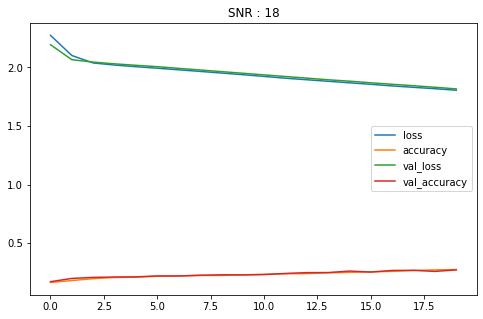

In [ ]:
plot_loss_acc(histories)

In [ ]:
acc_list, y_preds = test_models(models, feat_test, lab_test)

Test set accuracy mod 1 of SNR -20: 10%
Test set accuracy mod 2 of SNR -18: 10%
Test set accuracy mod 3 of SNR -16: 10%
Test set accuracy mod 4 of SNR -14: 15%
Test set accuracy mod 5 of SNR -12: 20%
Test set accuracy mod 6 of SNR -10: 27%
Test set accuracy mod 7 of SNR -8: 31%
Test set accuracy mod 8 of SNR -6: 32%
Test set accuracy mod 9 of SNR -4: 36%
Test set accuracy mod 10 of SNR -2: 31%
Test set accuracy mod 11 of SNR 0: 32%
Test set accuracy mod 12 of SNR 2: 29%
Test set accuracy mod 13 of SNR 4: 31%
Test set accuracy mod 14 of SNR 6: 31%
Test set accuracy mod 15 of SNR 8: 31%
Test set accuracy mod 16 of SNR 10: 31%
Test set accuracy mod 17 of SNR 12: 27%
Test set accuracy mod 18 of SNR 14: 31%
Test set accuracy mod 19 of SNR 16: 29%
Test set accuracy mod 20 of SNR 18: 29%


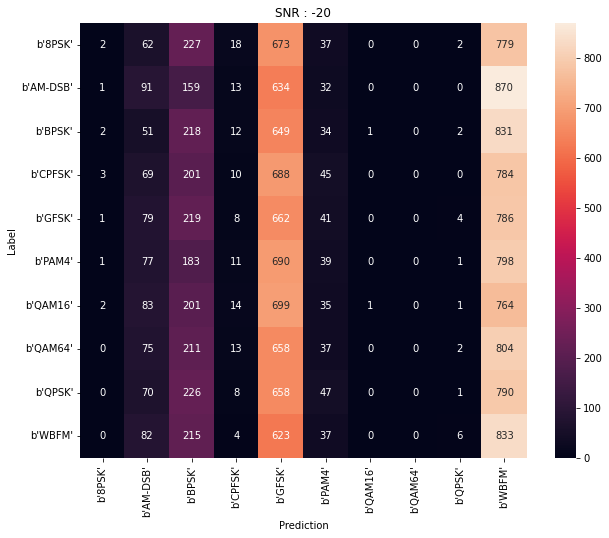

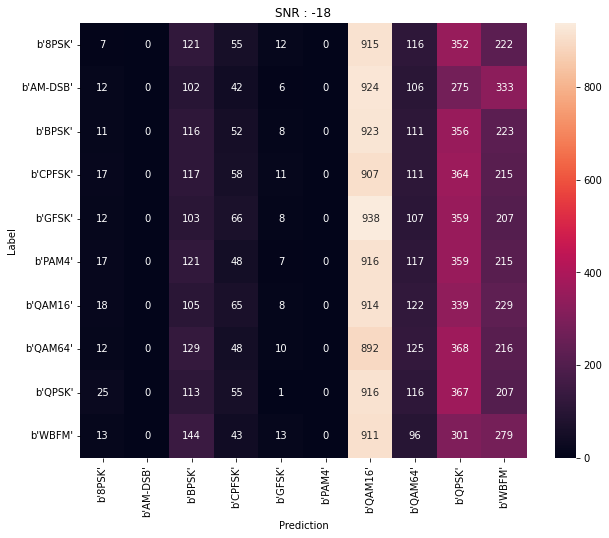

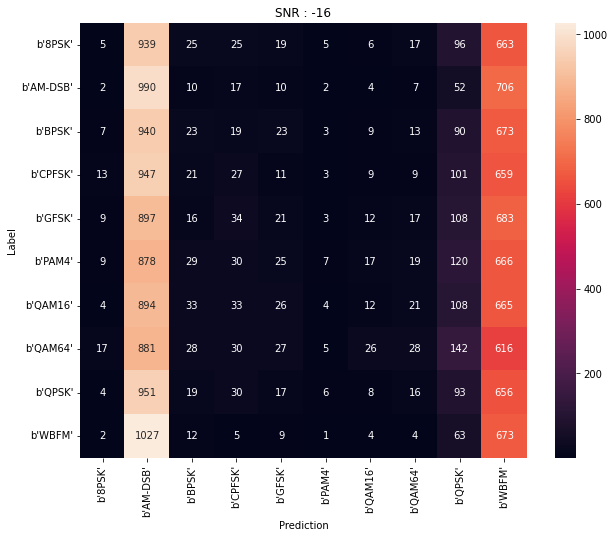

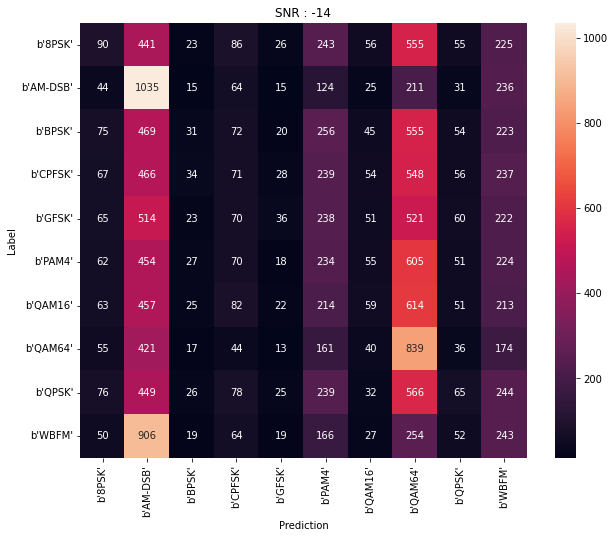

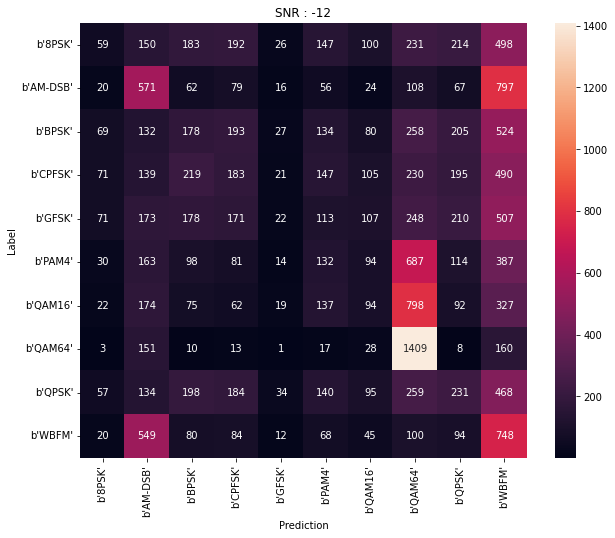

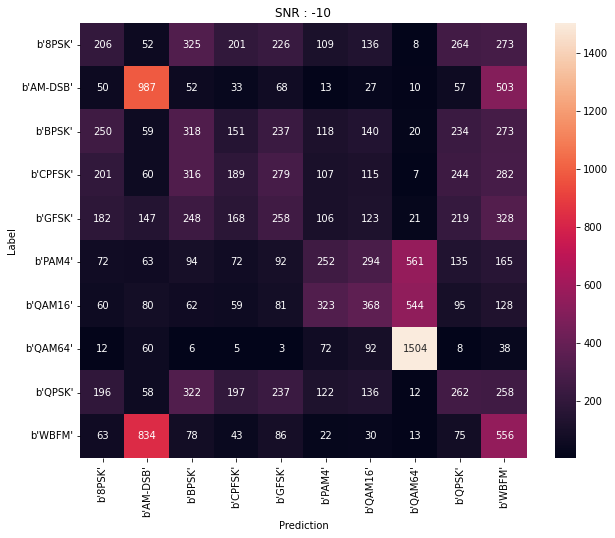

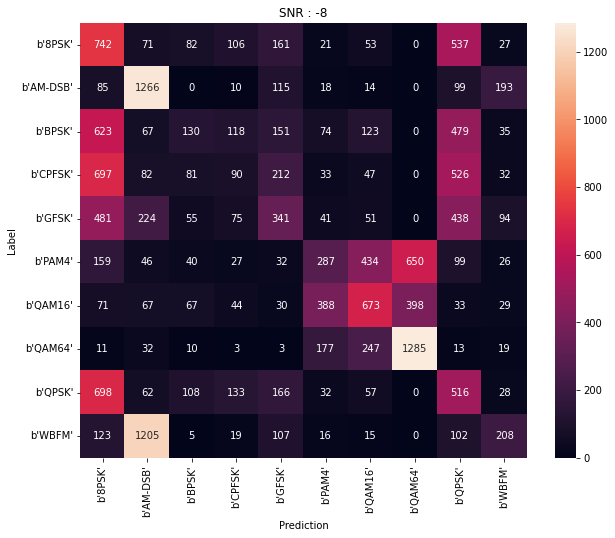

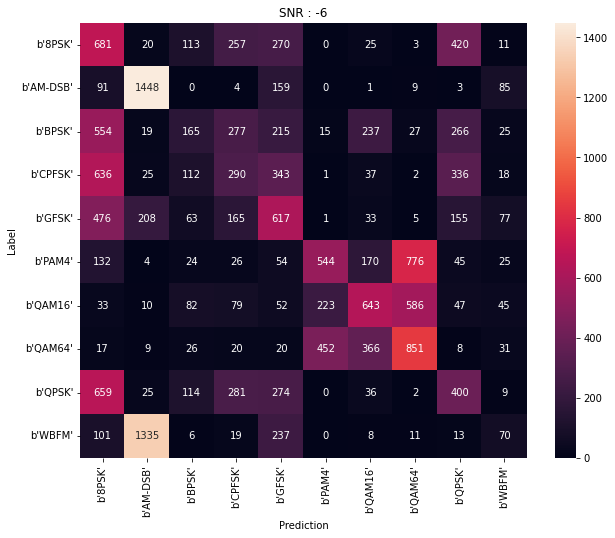

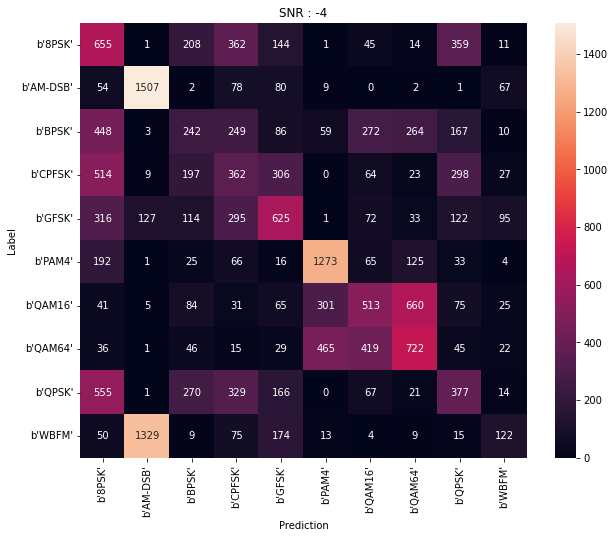

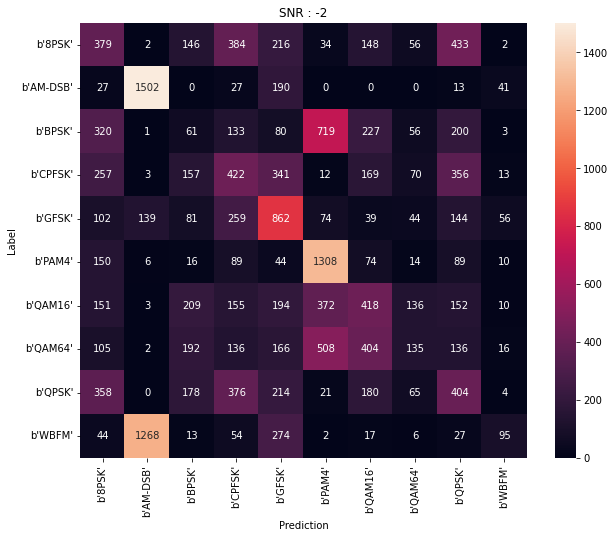

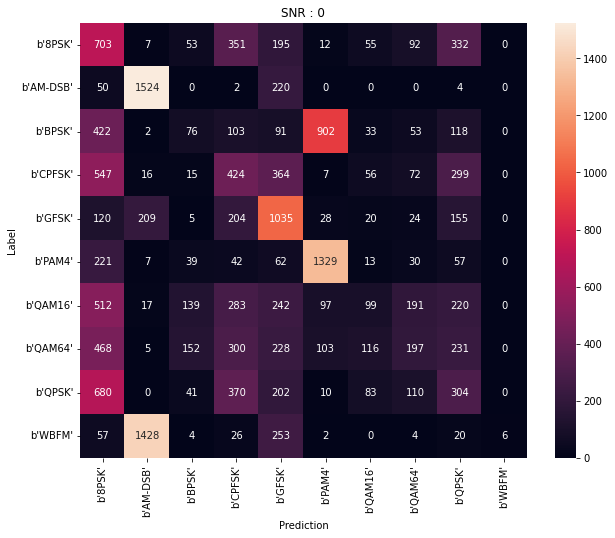

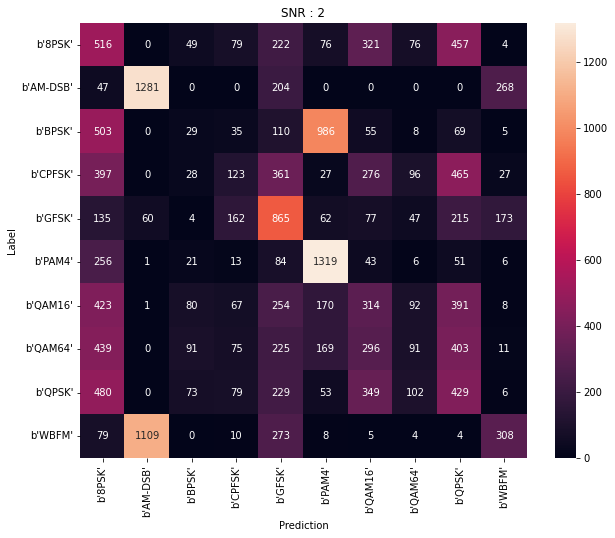

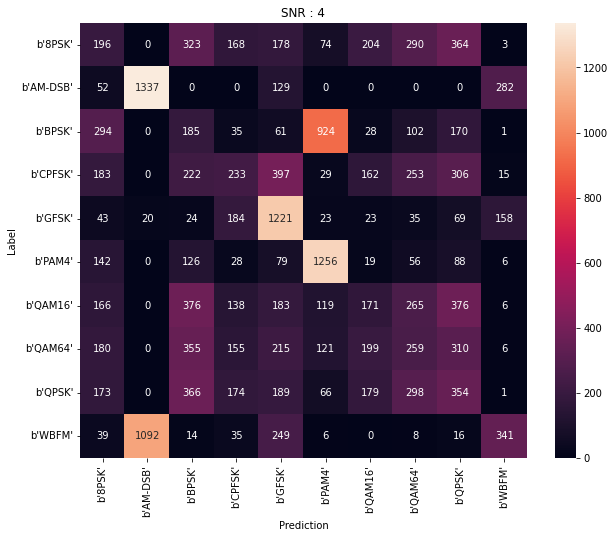

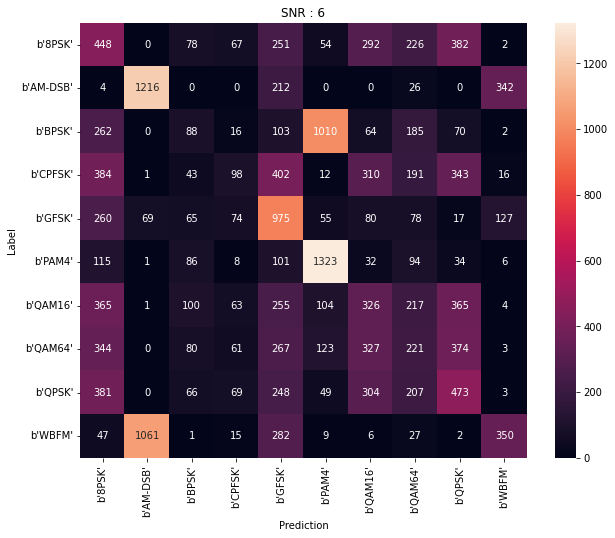

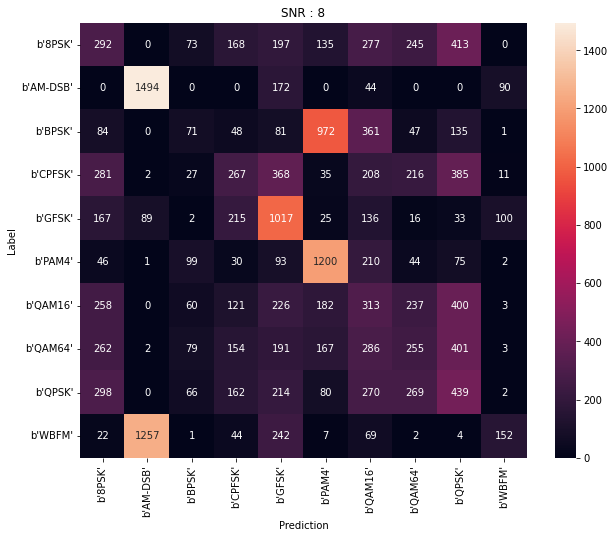

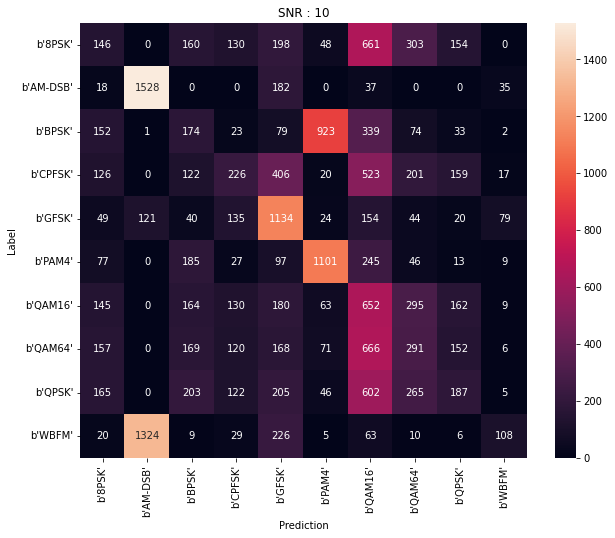

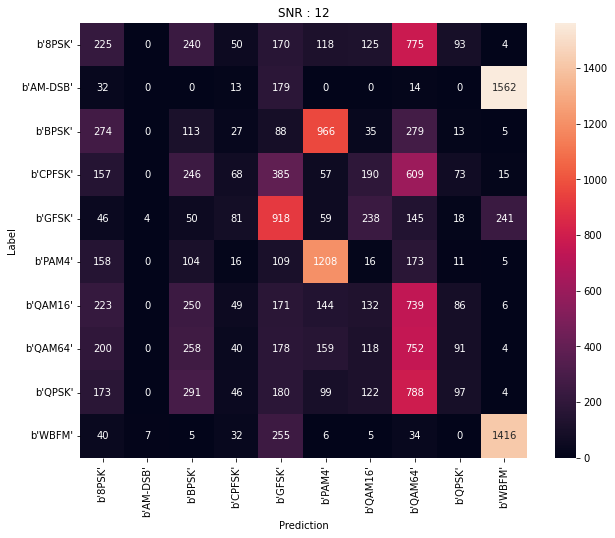

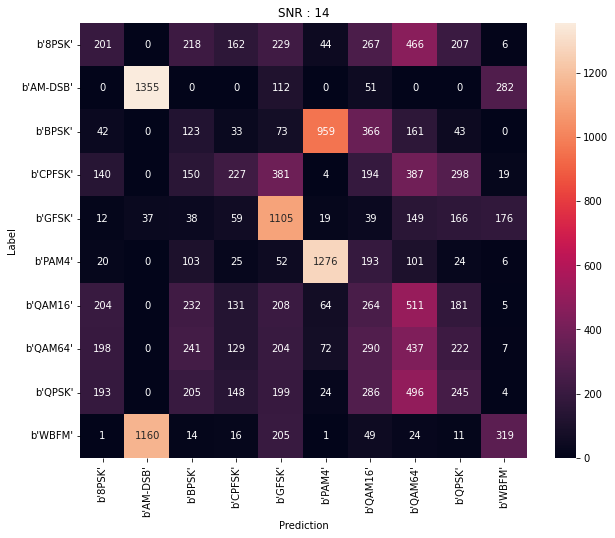

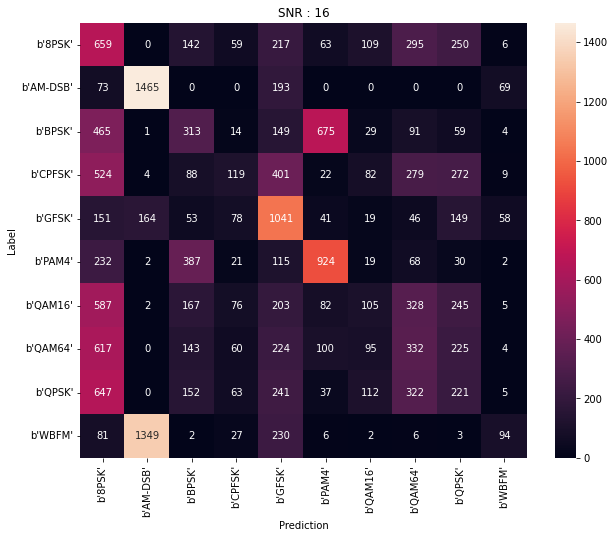

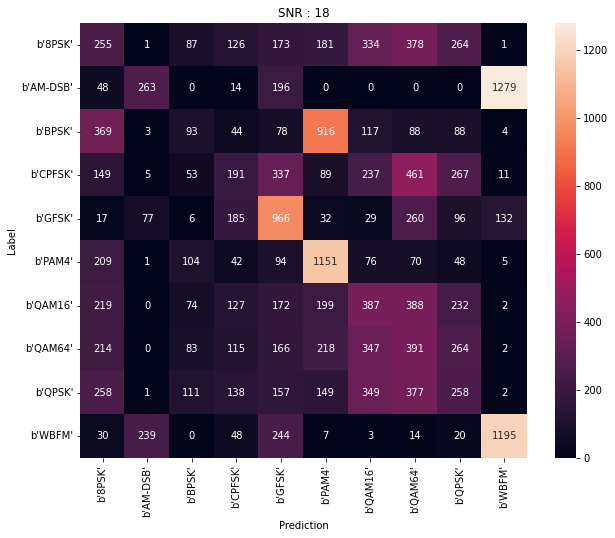

In [ ]:
confusion_matrixf(y_preds, lab_test)

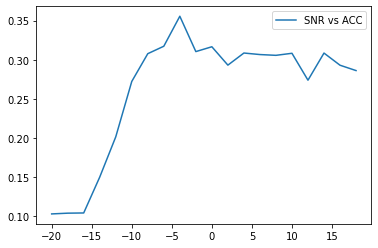

In [ ]:
plot_snr_acc(snrs, acc_list)

## RNN

## LSTM

# First derivative in time and Models


## CNN

In [20]:
def get_FDIT(X):
  features_FDIT = []
  for i, x in enumerate(X):
    fdit = normalize(np.gradient(x[:,0], axis = 1)), normalize(np.gradient(x[:,1], axis = 1)) 
    features_FDIT.append(fdit)

  return np.asarray(features_FDIT)


In [ ]:
features_FDIT = get_FDIT(X).reshape((20, 60000, 2, 128, 1))
print(features_FDIT.shape)

(20, 60000, 2, 128, 1)


In [ ]:
feat_train, feat_val, feat_test, lab_train, lab_val, lab_test = split(features_FDIT, label_enc)

In [ ]:
print(feat_train.shape, lab_train.shape)

(20, 39900, 2, 128, 1) (20, 39900, 10)


In [ ]:
models, histories = train_models(len(snrs), feat_train, feat_val, lab_train, lab_val, num_epochs, num_batch_size, 1e-2)


********************************************************* SNR -20 *********************************************************

Epoch 1/20
1247/1247 [==============================] - ETA: 0s - loss: 2.3043 - accuracy: 0.0965
Epoch 1: val_loss improved from inf to 2.30385, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 18s 6ms/step - loss: 2.3043 - accuracy: 0.0965 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 2/20
1243/1247 [============================>.] - ETA: 0s - loss: 2.3040 - accuracy: 0.0987
Epoch 2: val_loss improved from 2.30385 to 2.30371, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 6s 5ms/step - loss: 2.3040 - accuracy: 0.0986 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 3/20
1240/1247 [============================>.] - ETA: 0s - loss: 2.3039 - accuracy: 0.0992
Epoch 3: val_loss did not improve from 2.30371
1247/1247 [==============================] - 6s 5ms/step - loss: 2

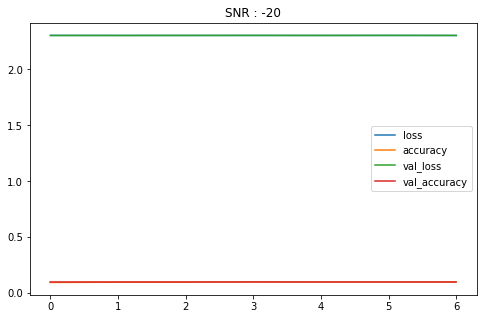

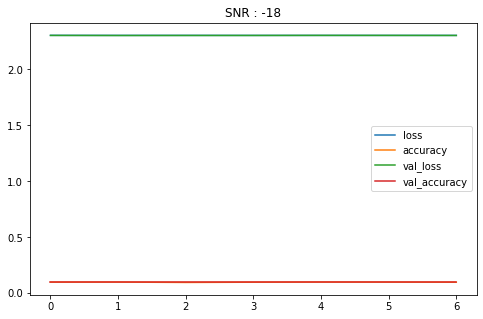

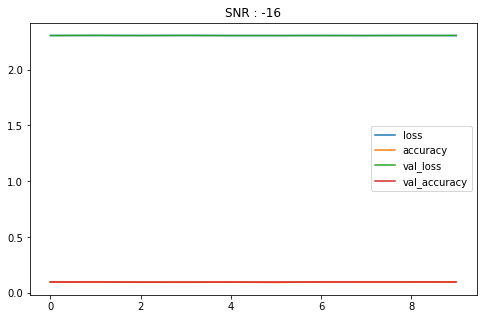

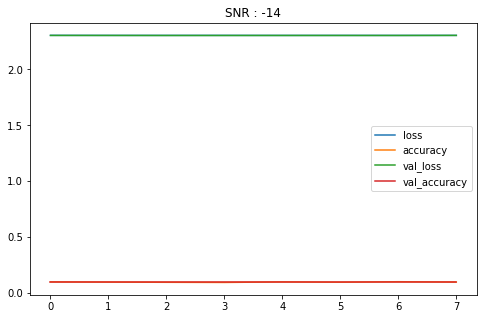

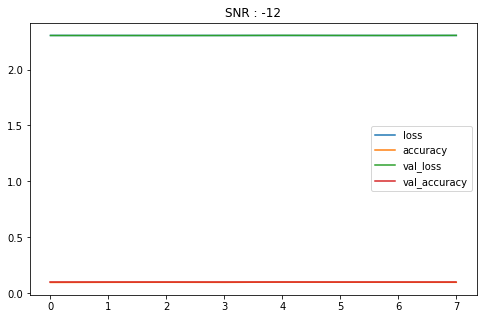

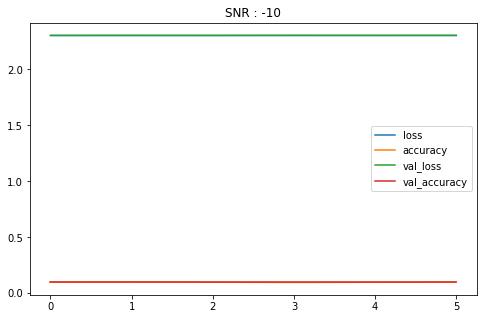

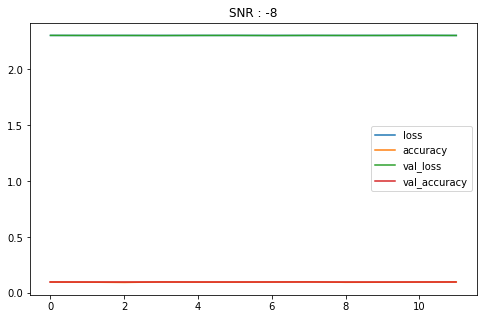

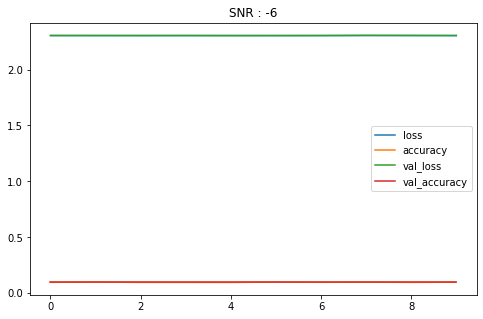

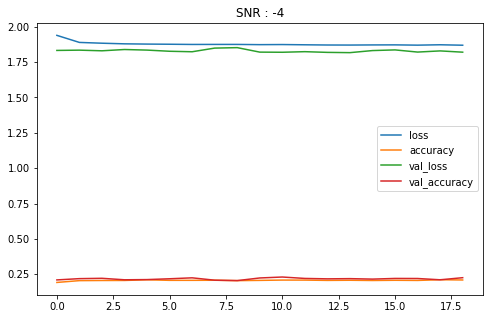

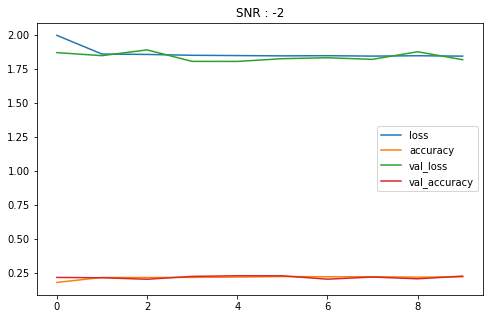

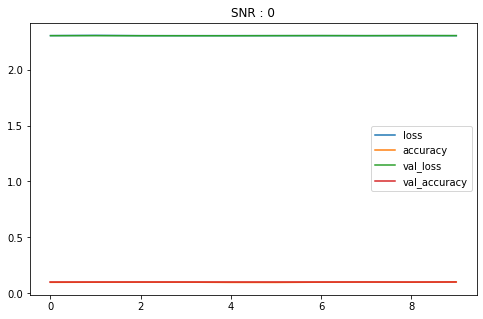

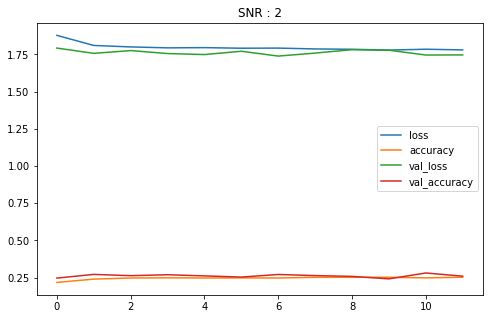

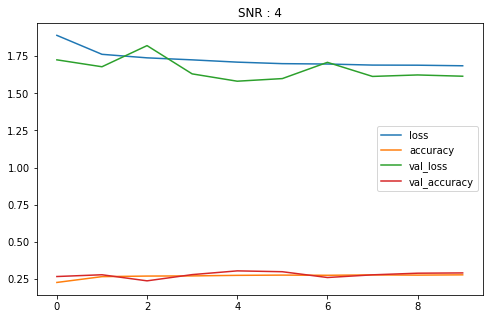

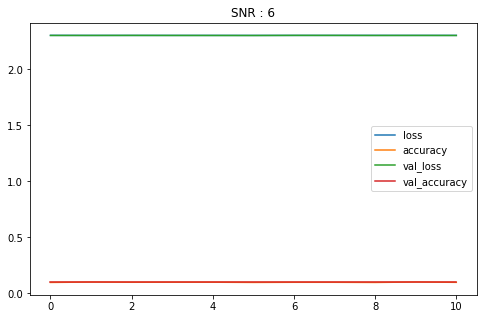

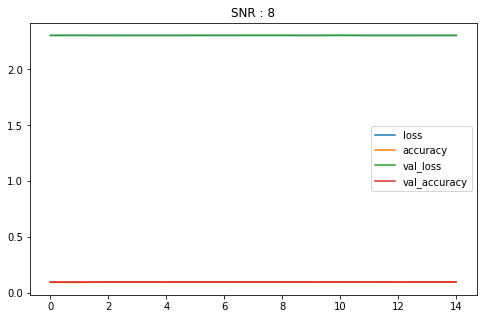

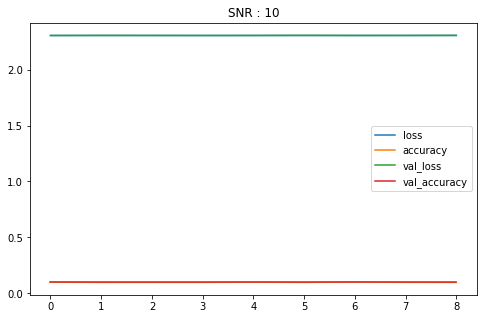

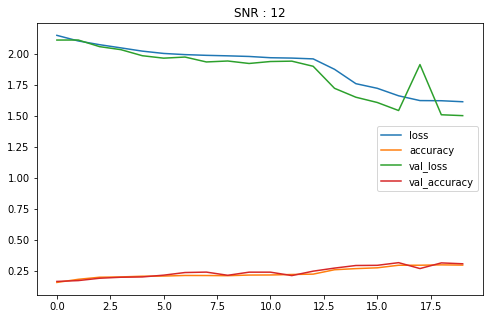

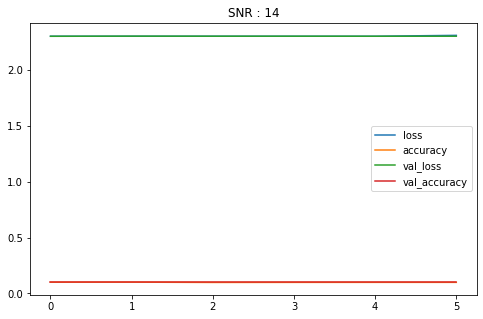

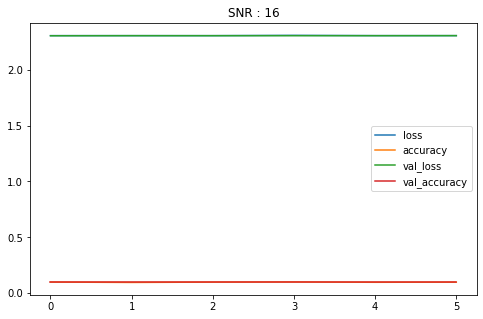

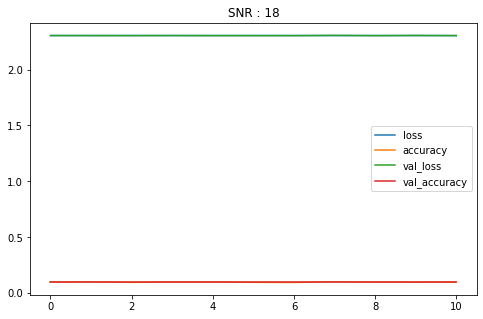

In [ ]:
plot_loss_acc(histories)

In [ ]:
acc_list, y_preds = test_models(models, feat_test, lab_test)

Test set accuracy mod 1 of SNR -20: 10%
Test set accuracy mod 2 of SNR -18: 10%
Test set accuracy mod 3 of SNR -16: 10%
Test set accuracy mod 4 of SNR -14: 10%
Test set accuracy mod 5 of SNR -12: 10%
Test set accuracy mod 6 of SNR -10: 10%
Test set accuracy mod 7 of SNR -8: 10%
Test set accuracy mod 8 of SNR -6: 10%
Test set accuracy mod 9 of SNR -4: 22%
Test set accuracy mod 10 of SNR -2: 22%
Test set accuracy mod 11 of SNR 0: 10%
Test set accuracy mod 12 of SNR 2: 27%
Test set accuracy mod 13 of SNR 4: 30%
Test set accuracy mod 14 of SNR 6: 10%
Test set accuracy mod 15 of SNR 8: 10%
Test set accuracy mod 16 of SNR 10: 10%
Test set accuracy mod 17 of SNR 12: 32%
Test set accuracy mod 18 of SNR 14: 10%
Test set accuracy mod 19 of SNR 16: 10%
Test set accuracy mod 20 of SNR 18: 10%


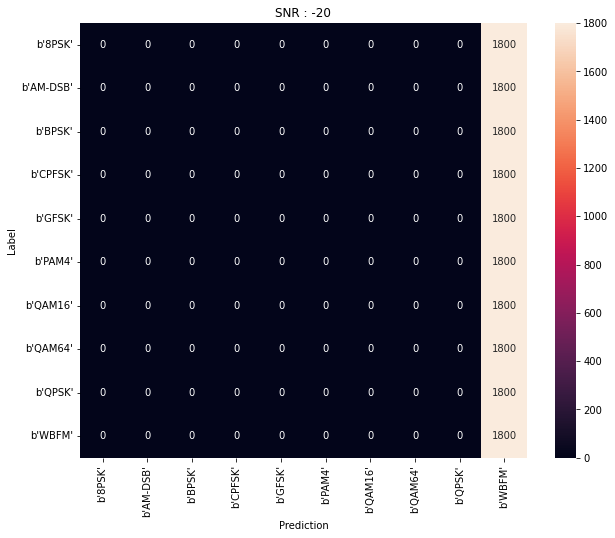

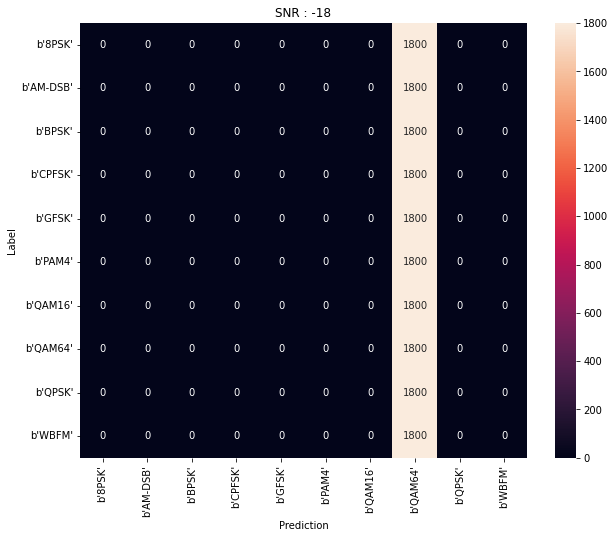

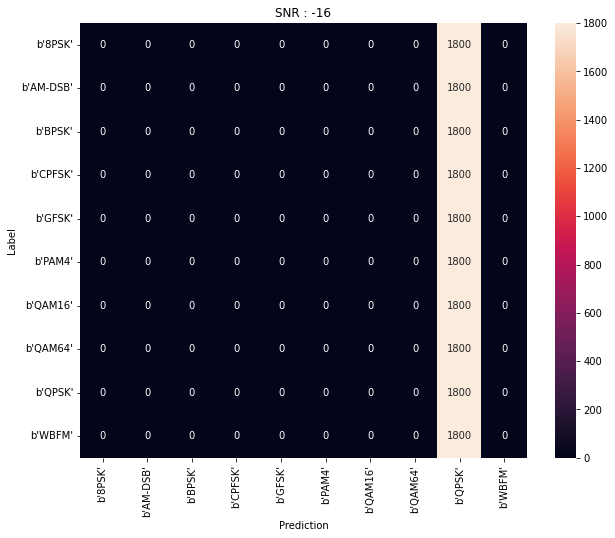

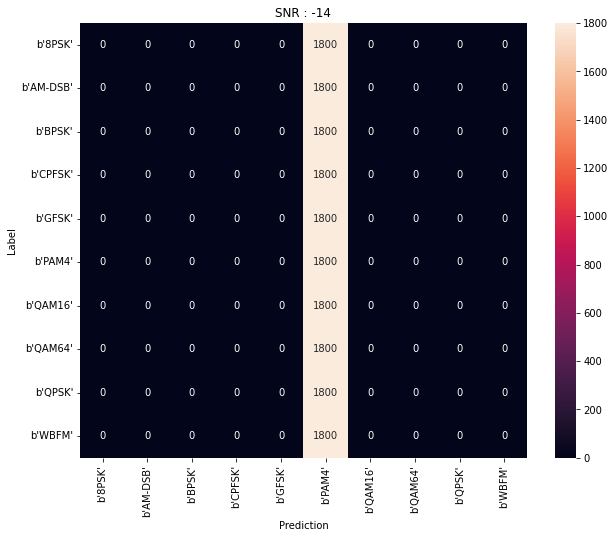

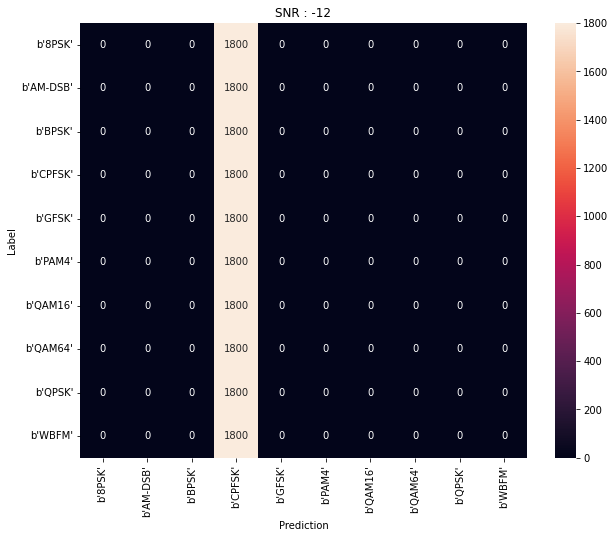

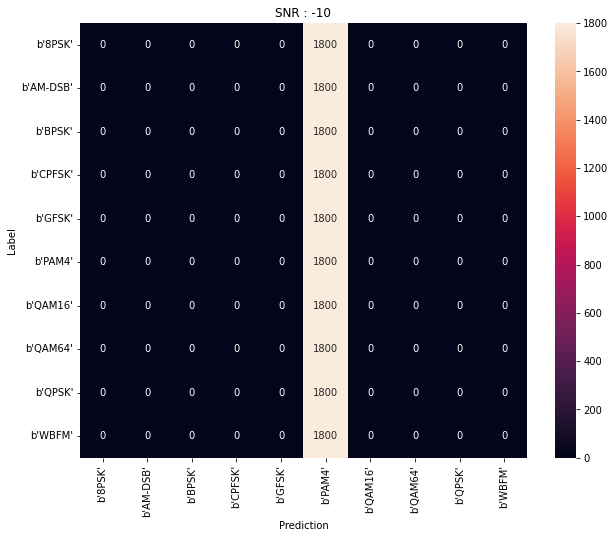

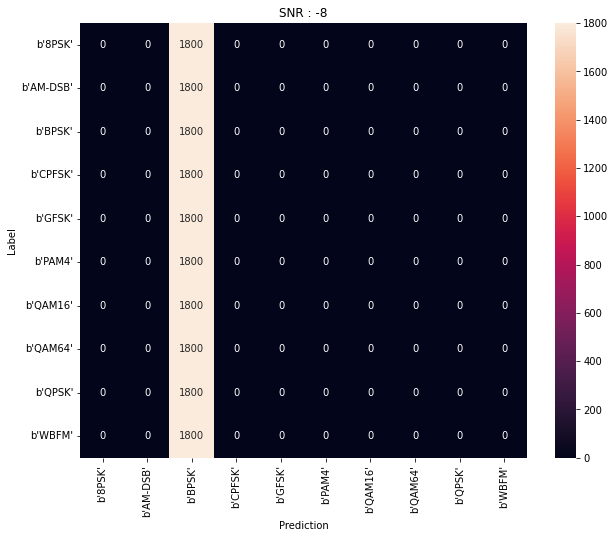

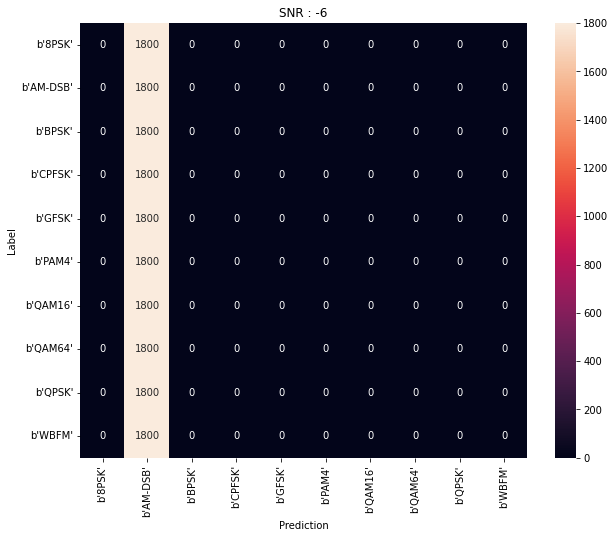

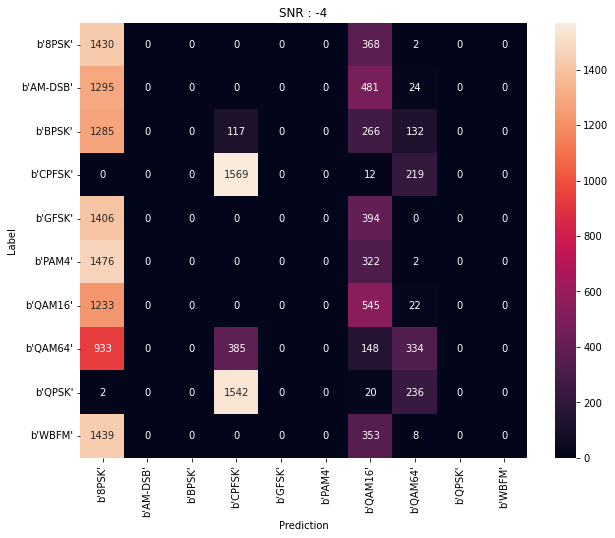

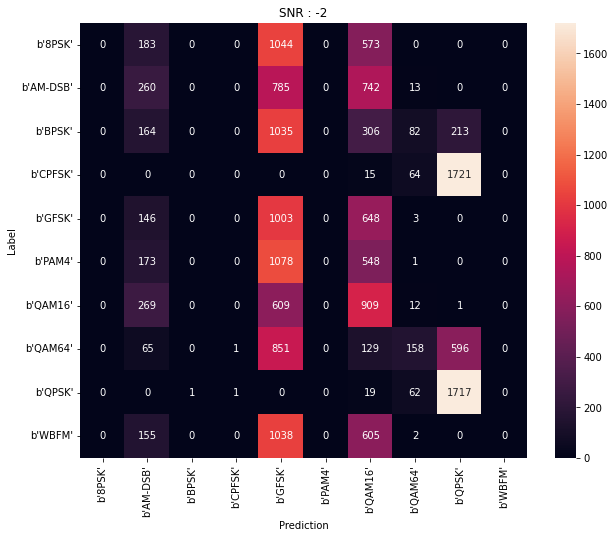

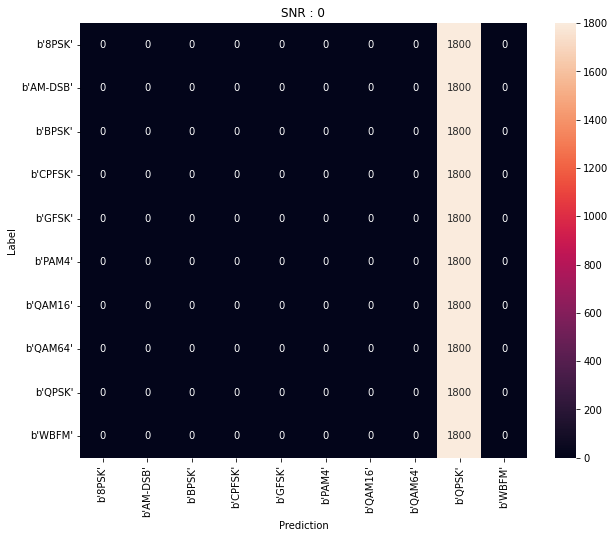

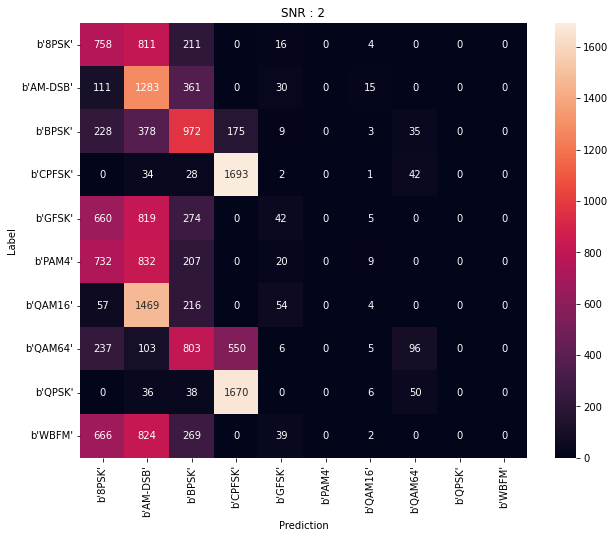

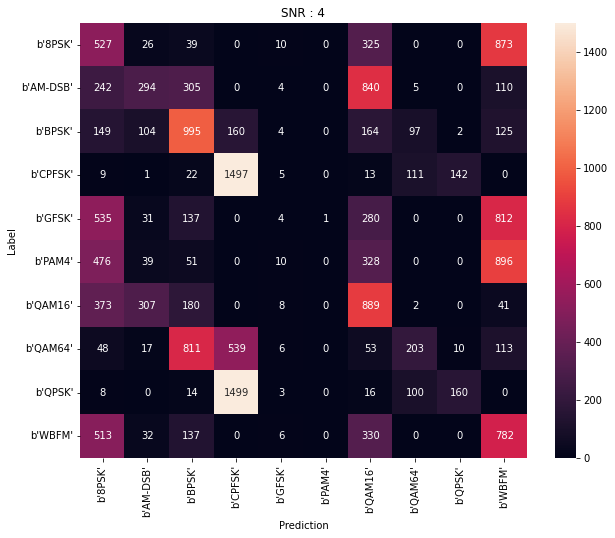

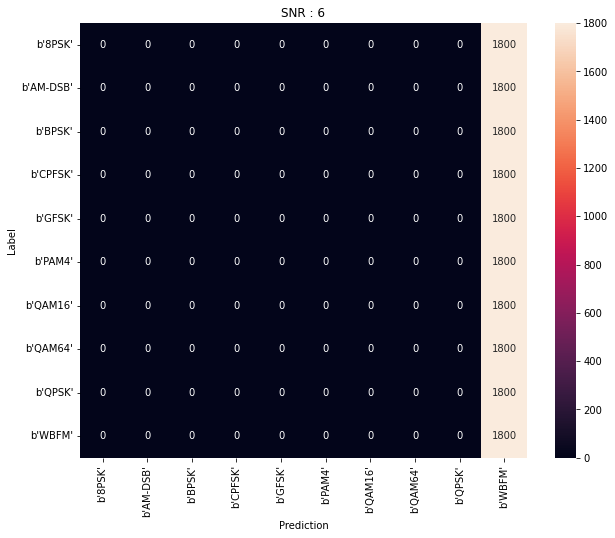

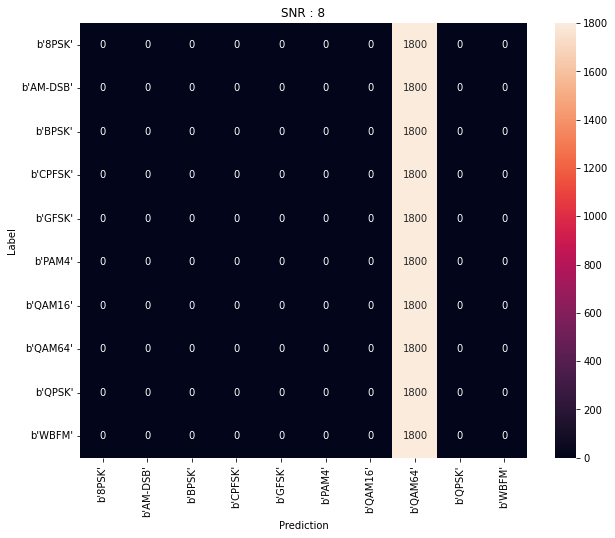

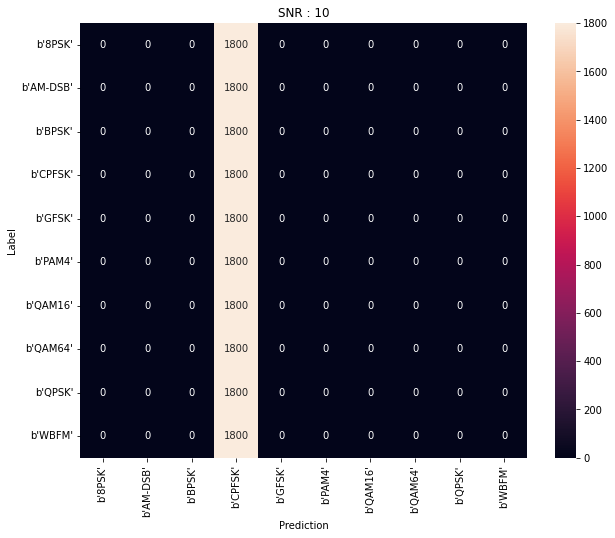

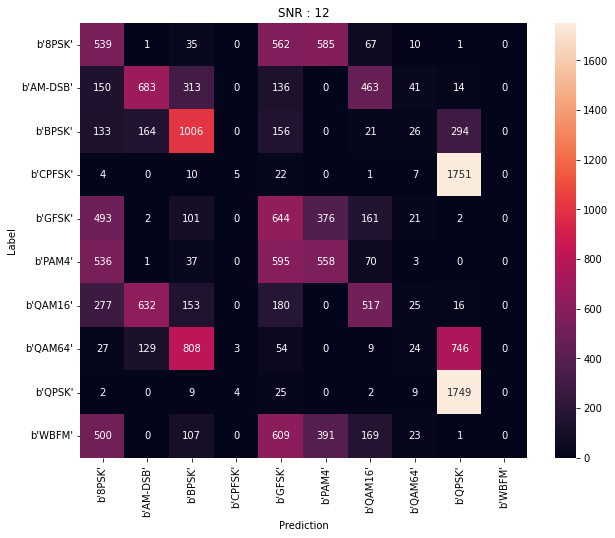

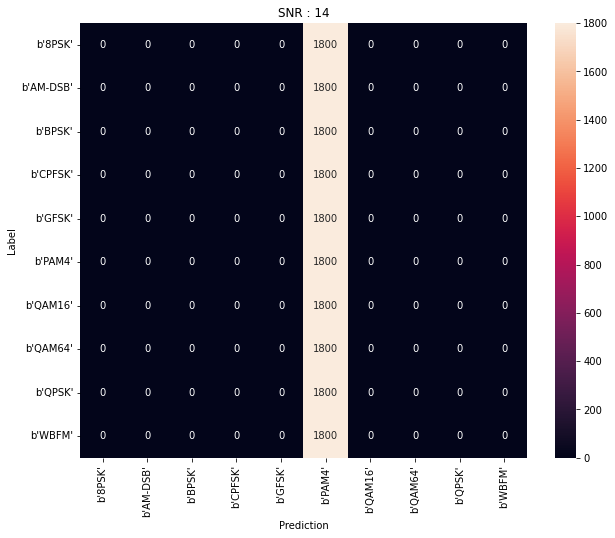

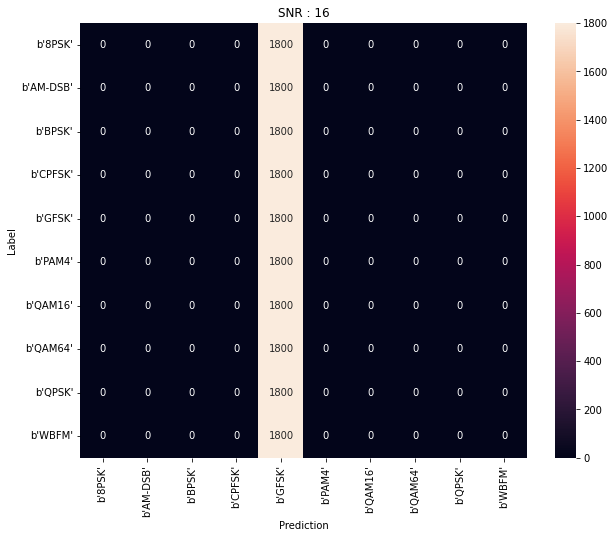

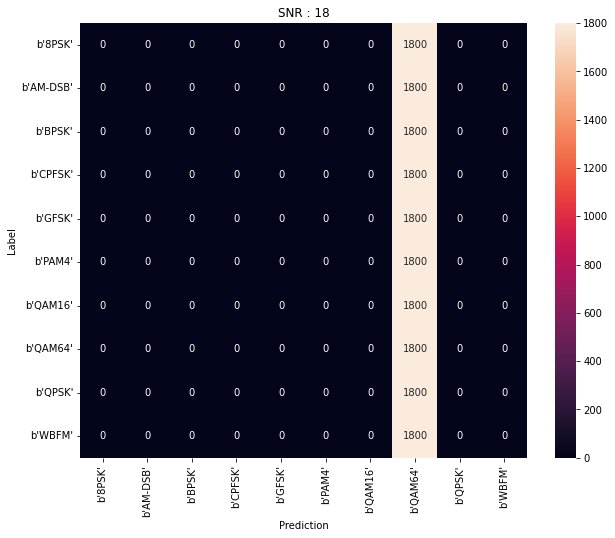

In [ ]:
confusion_matrixf(y_preds, lab_test)

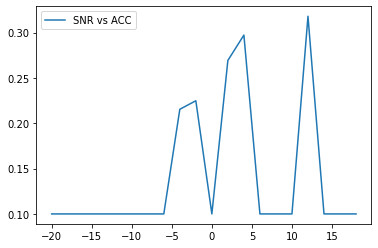

In [ ]:
plot_snr_acc(snrs, acc_list)

## RNN

## LSTM

# Integral in time and Models

## CNN

In [ ]:
features_IIT= integrate.cumtrapz(X, initial=0)
features_IIT = np.asarray(features_IIT).reshape((20, 60000, 2, 128, 1))
print(features_IIT.shape)

In [ ]:
feat_train, feat_val, feat_test, lab_train, lab_val, lab_test = split(features_IIT, label_enc)

In [ ]:
print(feat_train.shape, lab_train.shape)

(20, 39900, 2, 128, 1) (20, 39900, 10)


In [ ]:
models, histories = train_models(len(snrs), feat_train, feat_val, lab_train, lab_val, num_epochs, num_batch_size, 1e-5)


********************************************************* SNR -20 *********************************************************

Epoch 1/20
1247/1247 [==============================] - ETA: 0s - loss: 2.3026 - accuracy: 0.1009
Epoch 1: val_loss improved from inf to 2.30242, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 22s 7ms/step - loss: 2.3026 - accuracy: 0.1009 - val_loss: 2.3024 - val_accuracy: 0.1114
Epoch 2/20
1245/1247 [============================>.] - ETA: 0s - loss: 2.3022 - accuracy: 0.1078
Epoch 2: val_loss improved from 2.30242 to 2.30187, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 8s 6ms/step - loss: 2.3022 - accuracy: 0.1077 - val_loss: 2.3019 - val_accuracy: 0.1124
Epoch 3/20
1244/1247 [============================>.] - ETA: 0s - loss: 2.3014 - accuracy: 0.1072
Epoch 3: val_loss improved from 2.30187 to 2.30091, saving model to saved_models/classification0.hdf5
1247/1247 [

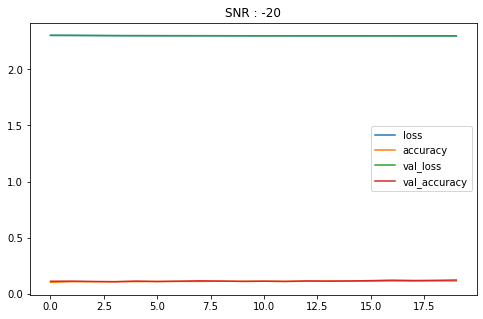

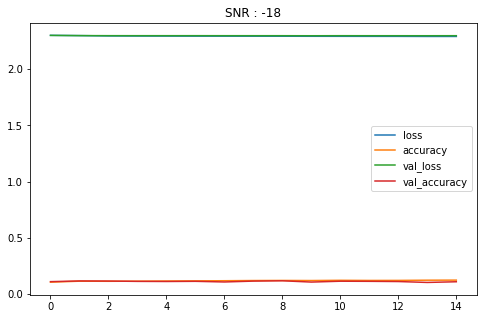

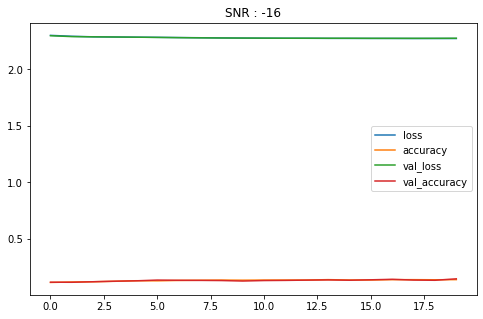

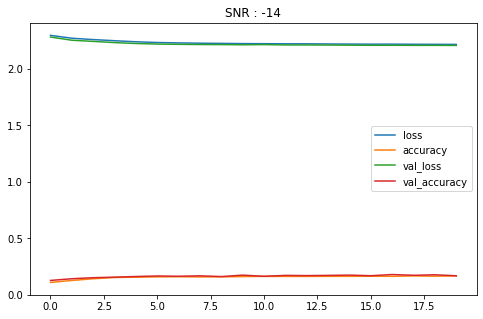

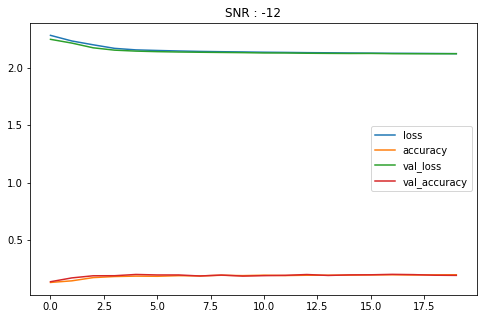

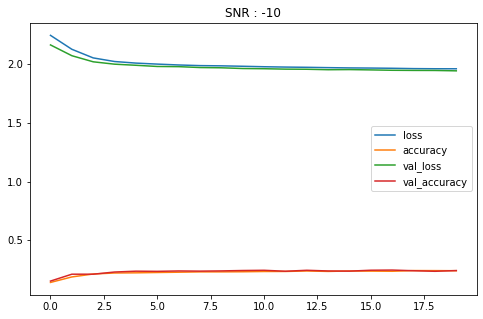

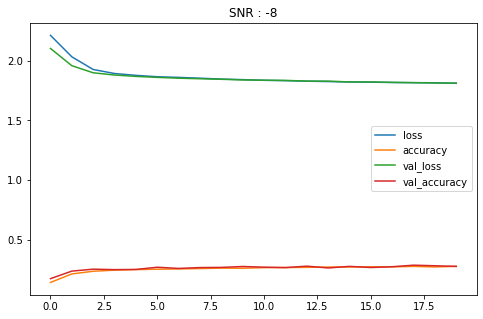

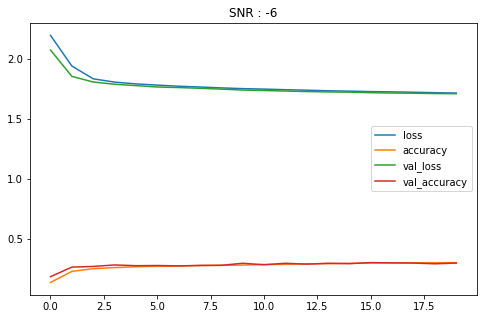

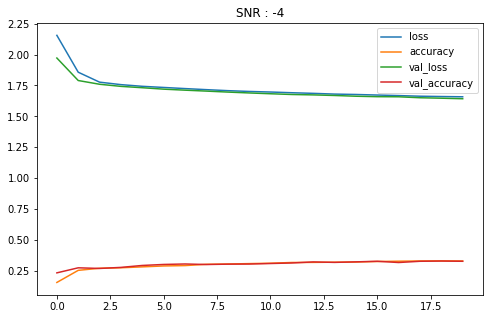

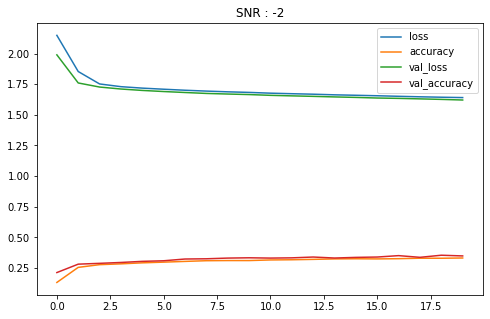

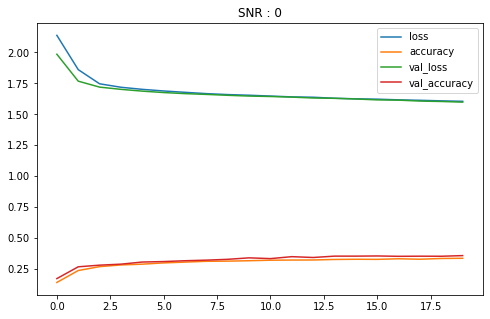

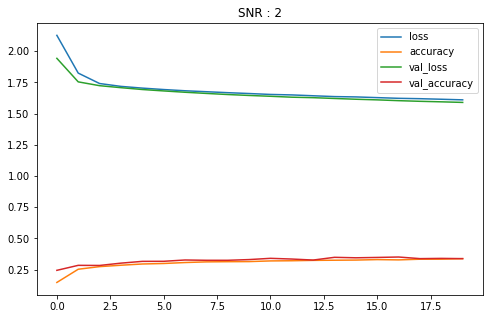

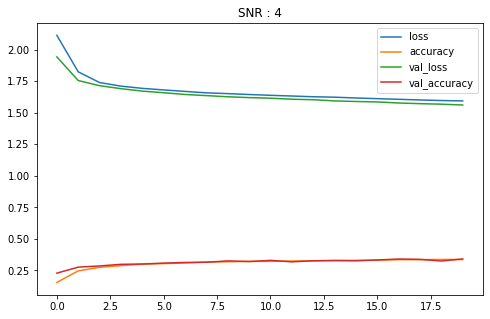

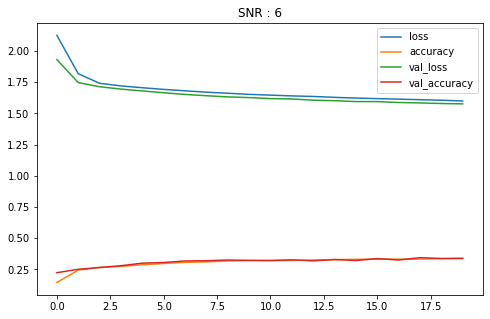

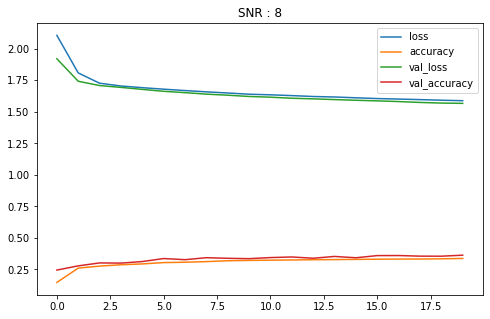

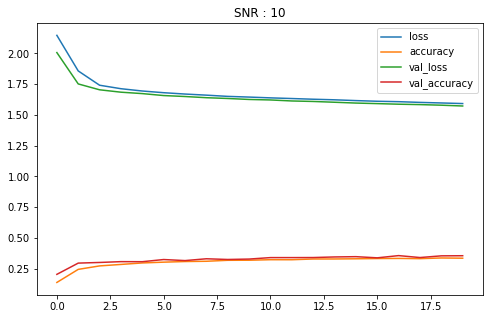

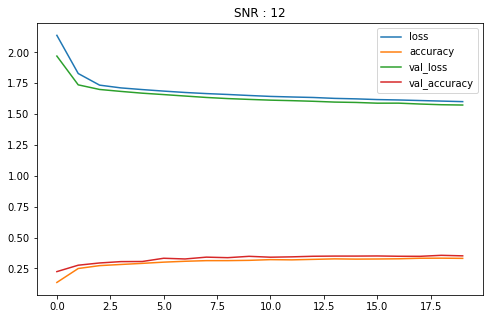

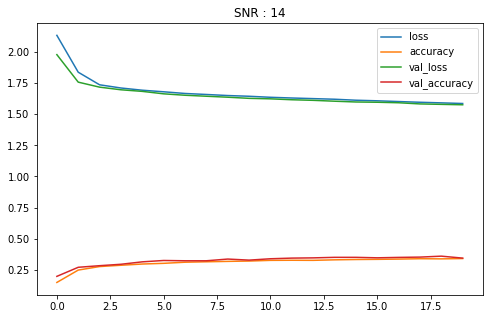

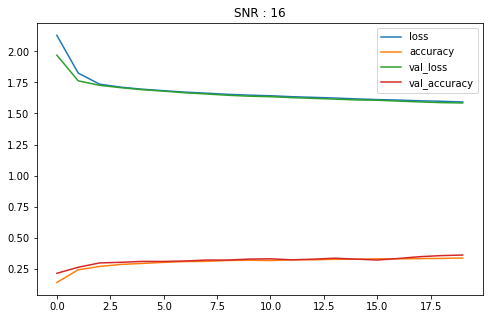

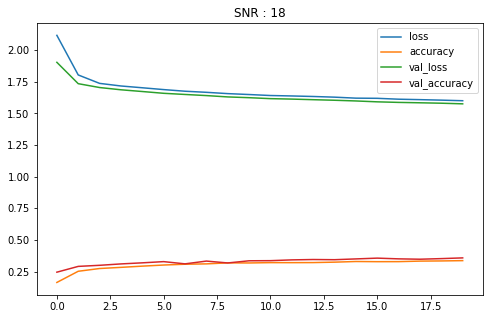

In [ ]:
plot_loss_acc(histories)

In [ ]:
acc_list, y_preds = test_models(models, feat_test, lab_test)

Test set accuracy mod 1 of SNR -20: 11%
Test set accuracy mod 2 of SNR -18: 11%
Test set accuracy mod 3 of SNR -16: 14%
Test set accuracy mod 4 of SNR -14: 16%
Test set accuracy mod 5 of SNR -12: 19%
Test set accuracy mod 6 of SNR -10: 24%
Test set accuracy mod 7 of SNR -8: 27%
Test set accuracy mod 8 of SNR -6: 31%
Test set accuracy mod 9 of SNR -4: 33%
Test set accuracy mod 10 of SNR -2: 34%
Test set accuracy mod 11 of SNR 0: 34%
Test set accuracy mod 12 of SNR 2: 35%
Test set accuracy mod 13 of SNR 4: 35%
Test set accuracy mod 14 of SNR 6: 35%
Test set accuracy mod 15 of SNR 8: 35%
Test set accuracy mod 16 of SNR 10: 35%
Test set accuracy mod 17 of SNR 12: 34%
Test set accuracy mod 18 of SNR 14: 35%
Test set accuracy mod 19 of SNR 16: 35%
Test set accuracy mod 20 of SNR 18: 35%


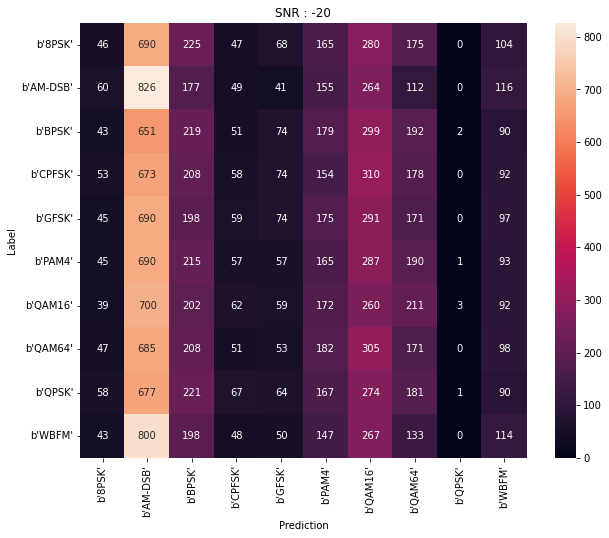

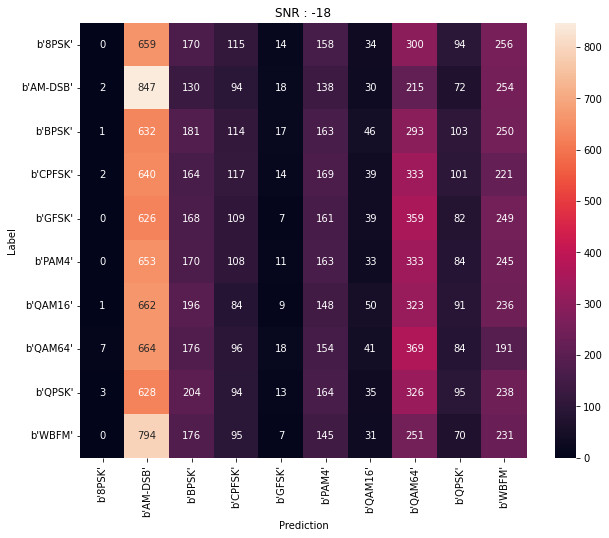

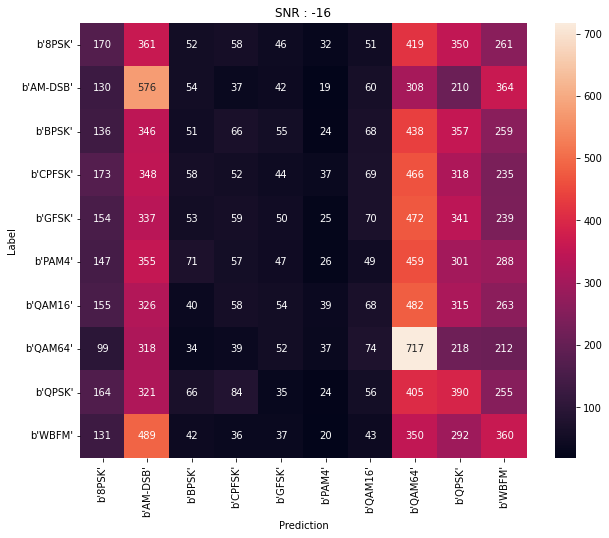

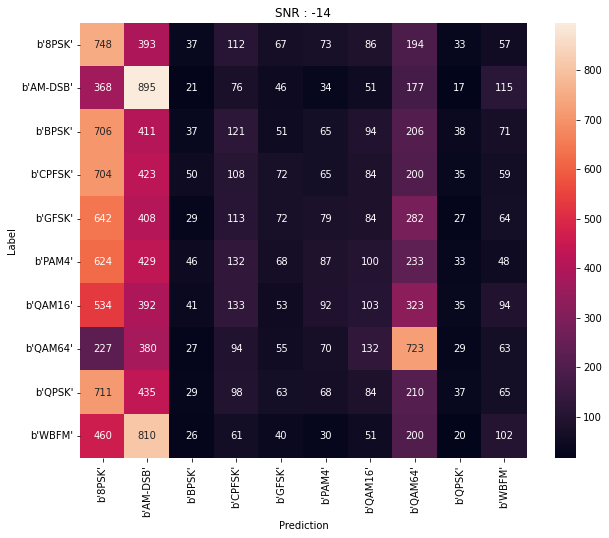

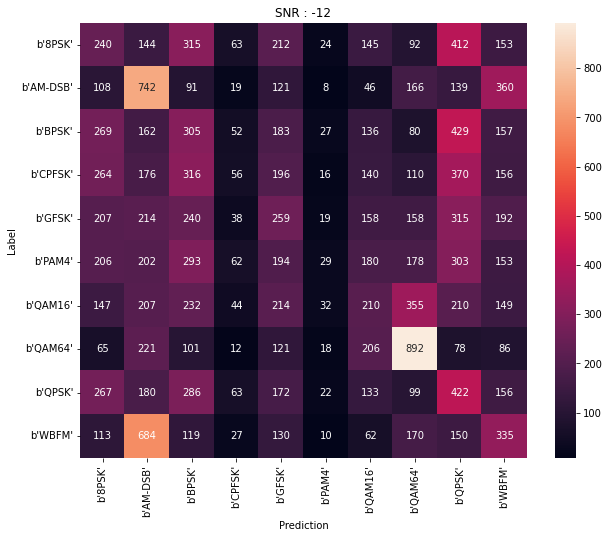

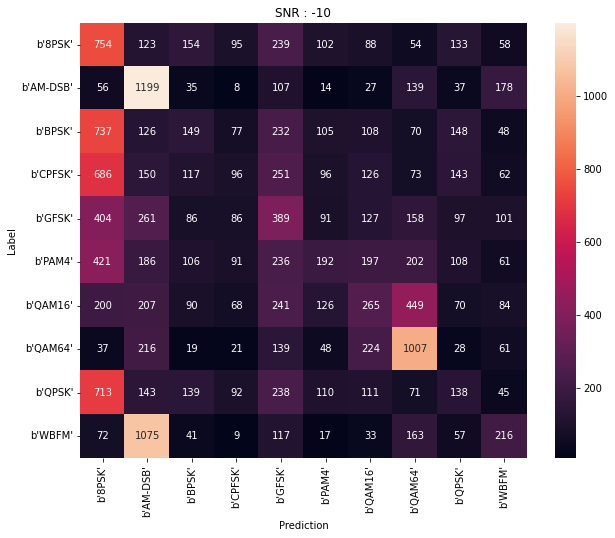

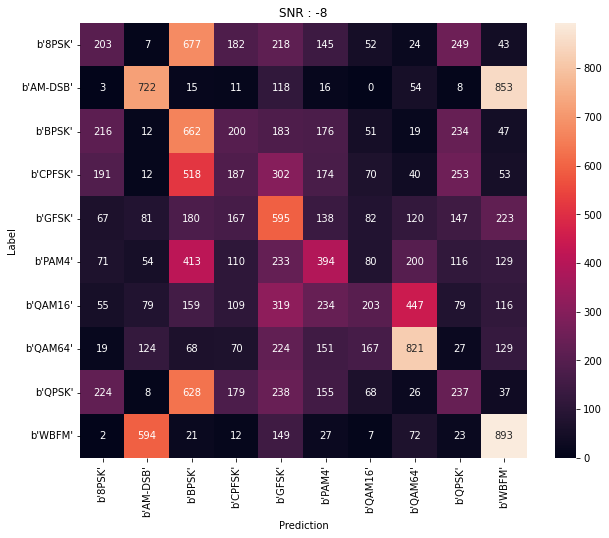

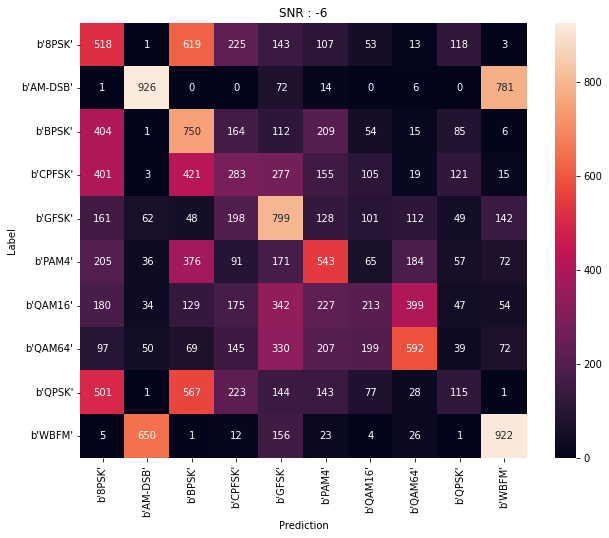

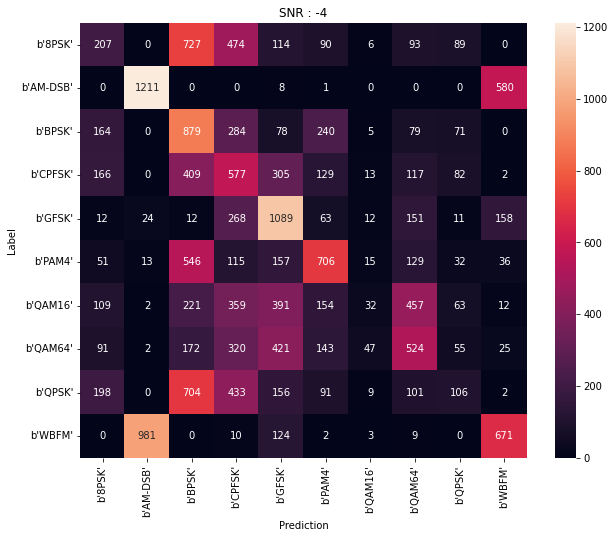

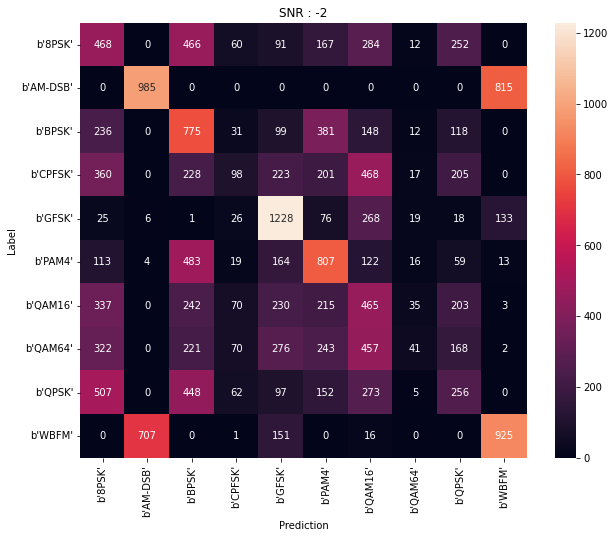

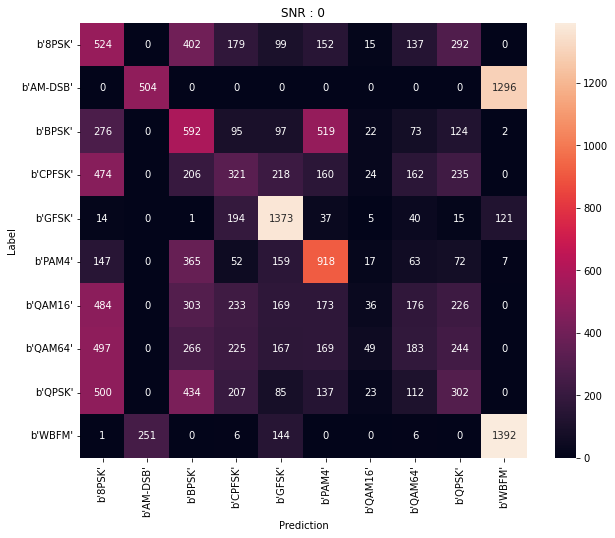

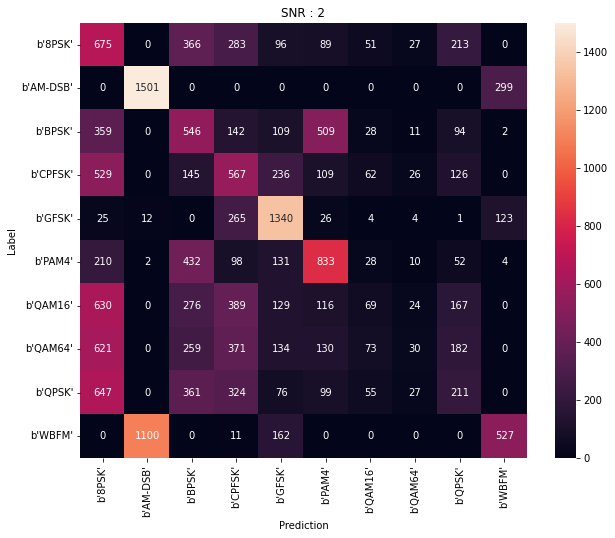

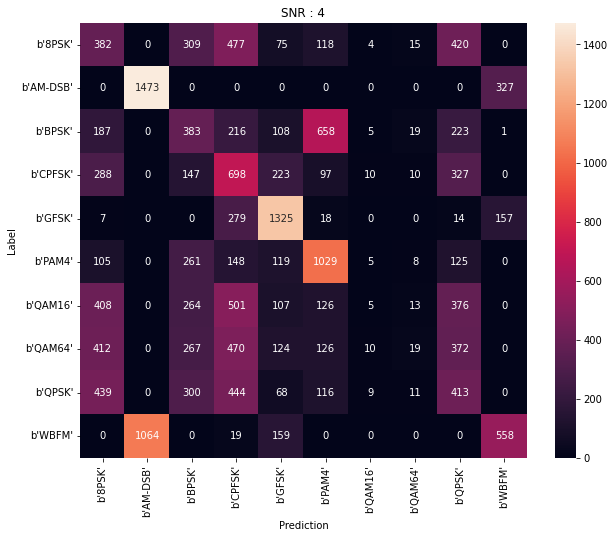

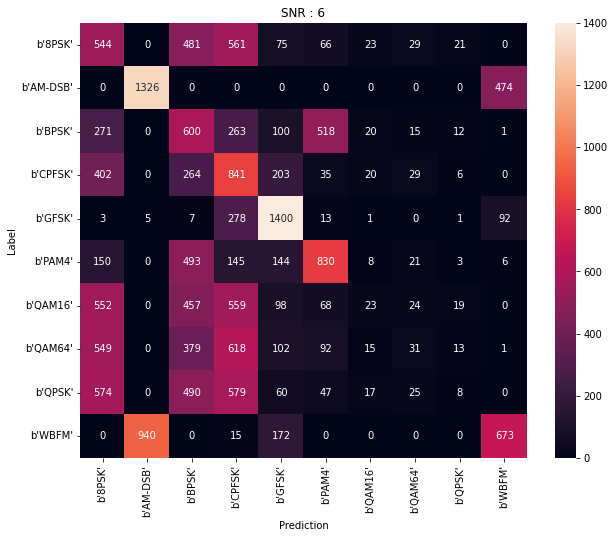

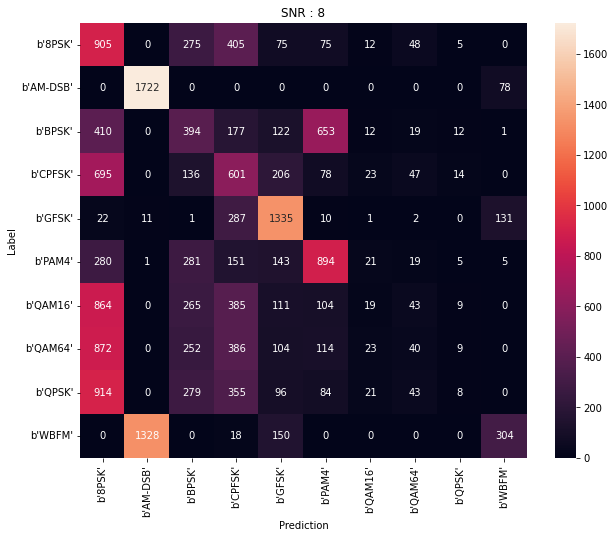

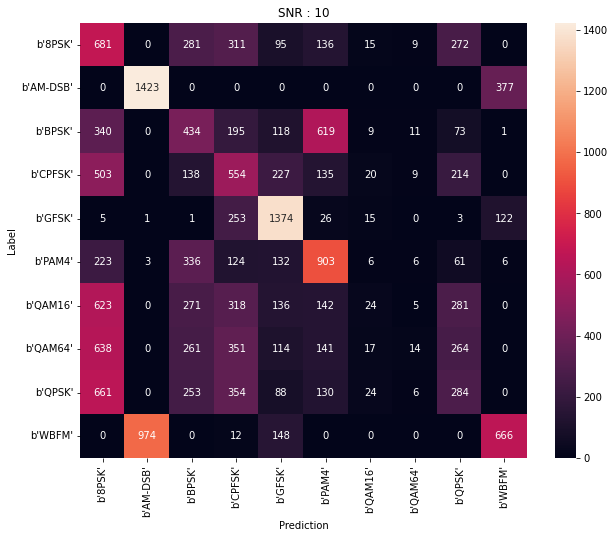

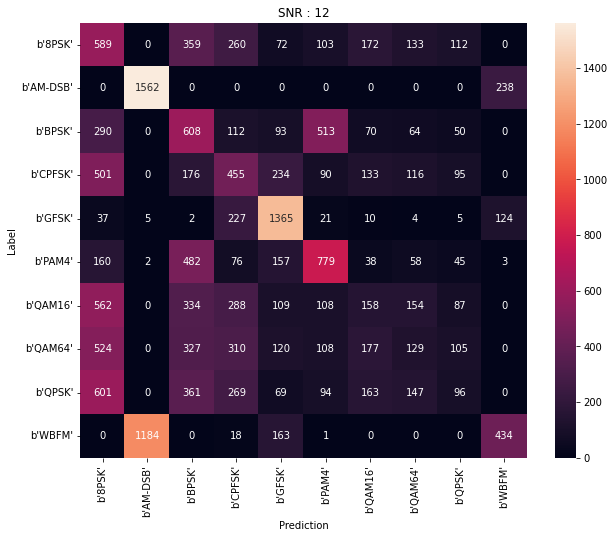

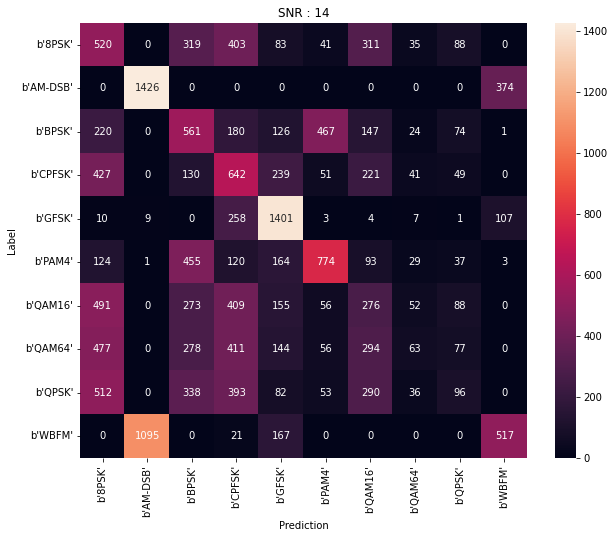

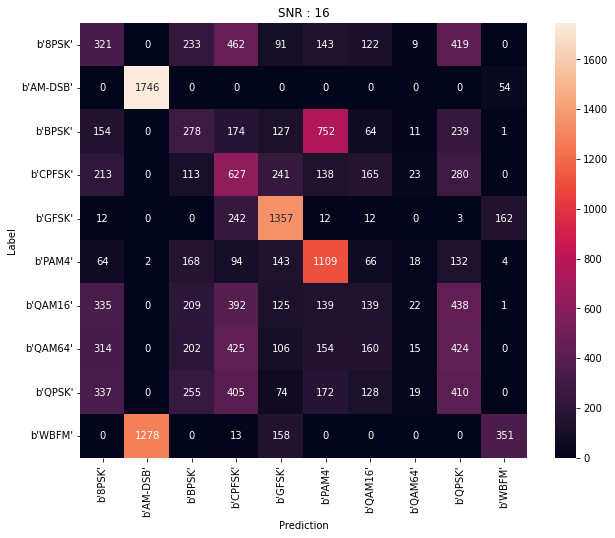

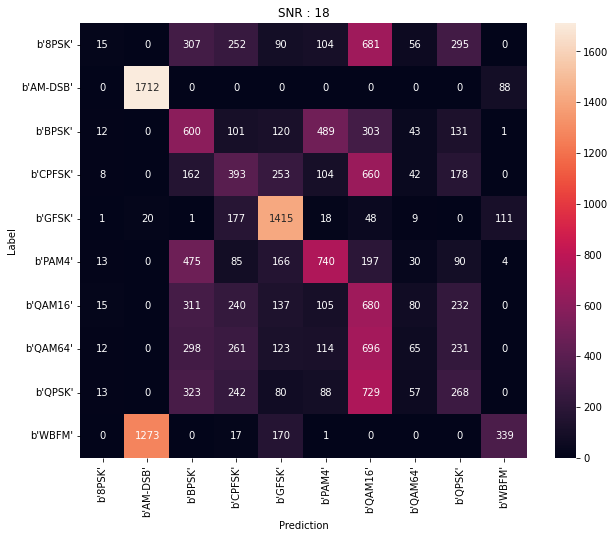

In [ ]:
confusion_matrixf(y_preds, lab_test)

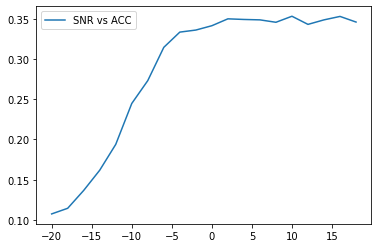

In [ ]:
plot_snr_acc(snrs, acc_list)

## RNN

## LSTM

# Combinations of 1,2 and 3 and Models

## CNN

In [21]:
features_FDIT = get_FDIT(X).reshape((20, 60000, 2, 128, 1))
print(features_FDIT.shape)

(20, 60000, 2, 128, 1)


In [22]:
features_IIT = integrate.cumtrapz(X, initial=0)
features_IIT = np.asarray(features_IIT).reshape((20, 60000, 2, 128, 1))
print(features_IIT.shape)  

(20, 60000, 2, 128, 1)


In [23]:
Combined_features = np.concatenate((X.reshape((20, 60000, 2, 128, 1)) ,features_FDIT, features_IIT), axis=2)
Combined_features = np.asarray(Combined_features)
print(Combined_features.shape)

(20, 60000, 6, 128, 1)


In [24]:
del features_FDIT
del features_IIT
del X
del label
del Data

In [25]:
feat_train, feat_val, feat_test, lab_train, lab_val, lab_test = split(Combined_features, label_enc)

In [27]:
print(feat_train.shape, lab_train.shape)

(20, 39900, 6, 128, 1) (20, 39900, 10)


In [26]:
del Combined_features

In [28]:
models, histories = train_models(len(snrs), feat_train, feat_val, lab_train, lab_val, num_epochs, num_batch_size, 1e-2)


********************************************************* SNR -20 *********************************************************

Epoch 1/20
1247/1247 [==============================] - ETA: 0s - loss: 2.3053 - accuracy: 0.1002
Epoch 1: val_loss improved from inf to 2.30359, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 25s 11ms/step - loss: 2.3053 - accuracy: 0.1002 - val_loss: 2.3036 - val_accuracy: 0.1000
Epoch 2/20
1244/1247 [============================>.] - ETA: 0s - loss: 2.3040 - accuracy: 0.1008
Epoch 2: val_loss did not improve from 2.30359
1247/1247 [==============================] - 12s 10ms/step - loss: 2.3040 - accuracy: 0.1007 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 3/20
1246/1247 [============================>.] - ETA: 0s - loss: 2.3040 - accuracy: 0.1018
Epoch 3: val_loss improved from 2.30359 to 2.30334, saving model to saved_models/classification0.hdf5
1247/1247 [==============================] - 12s 10ms/step - lo

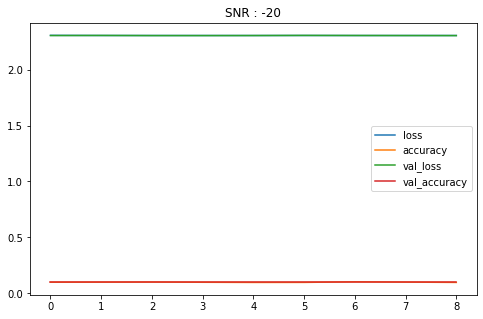

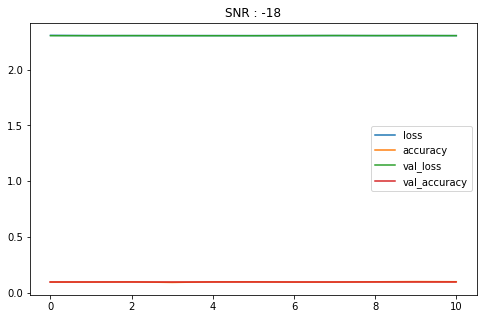

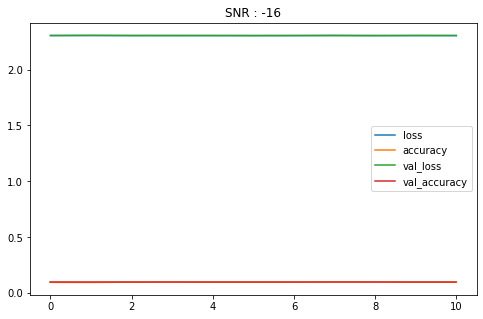

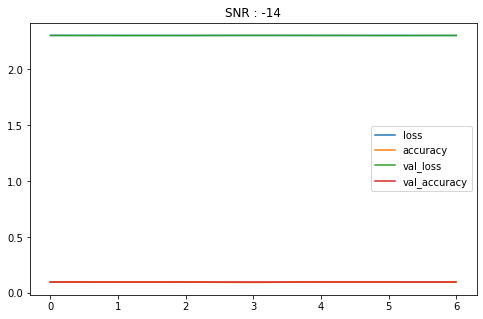

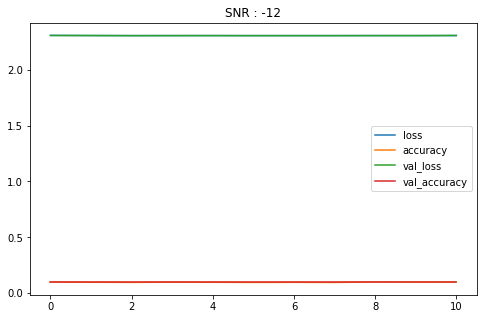

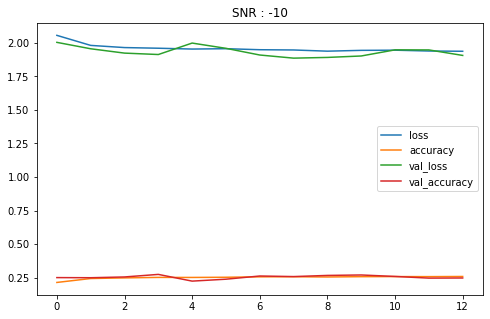

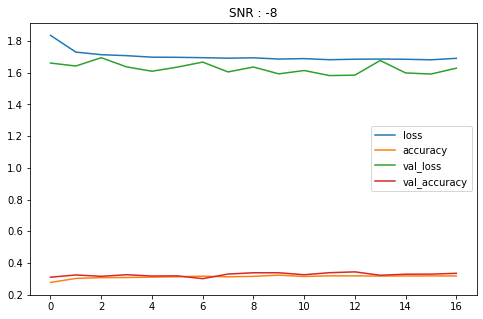

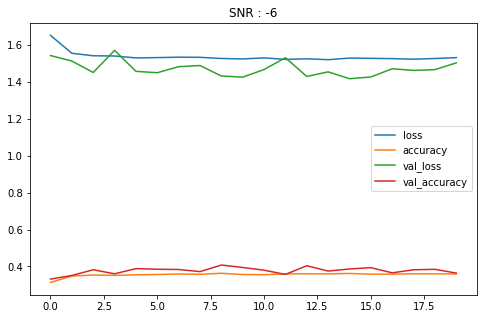

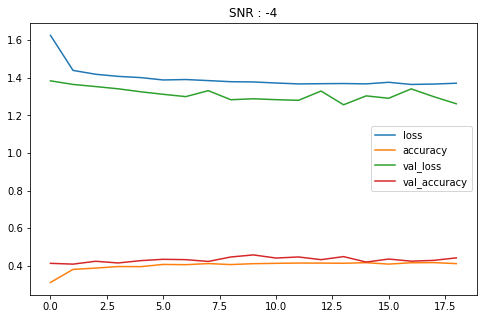

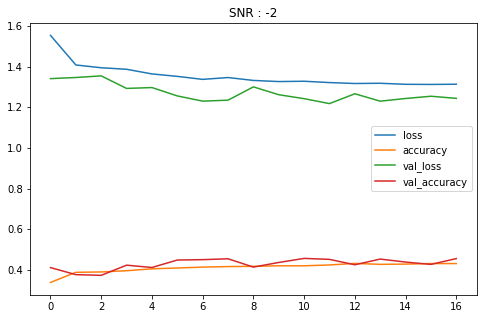

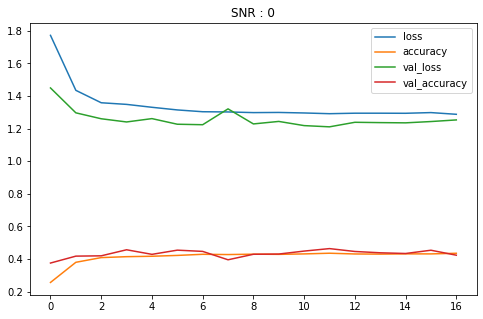

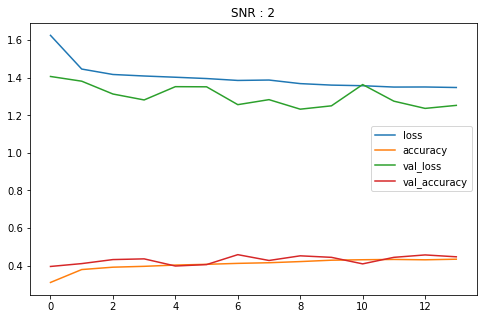

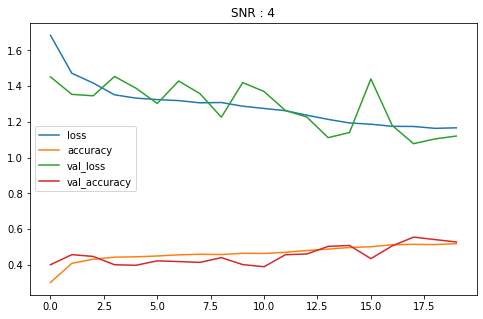

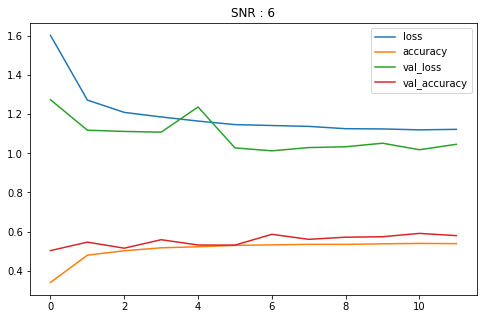

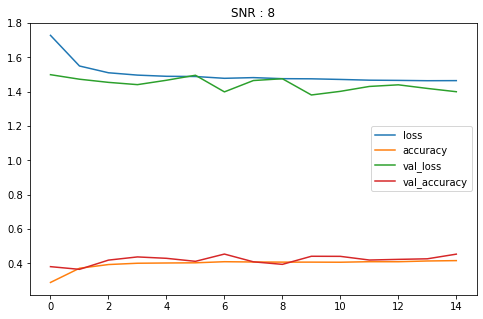

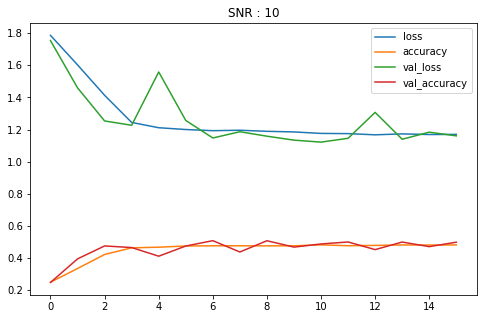

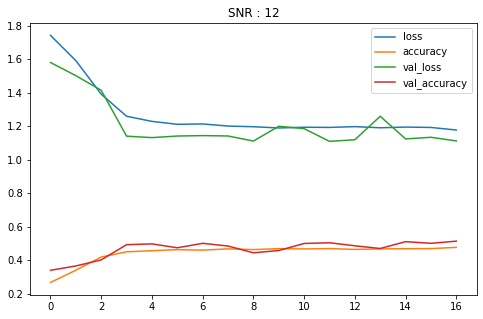

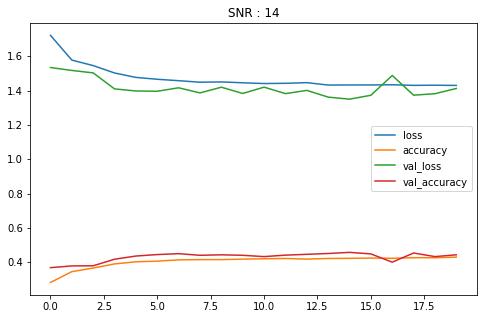

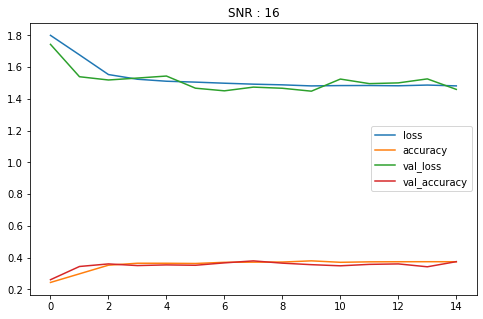

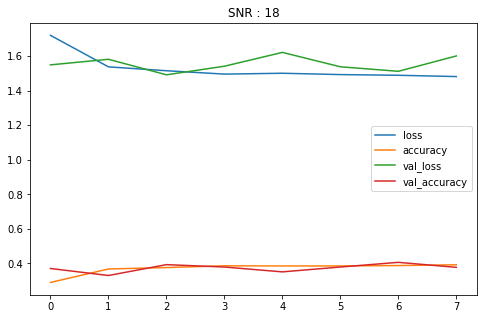

In [29]:
plot_loss_acc(histories)  

In [30]:
acc_list, y_preds = test_models(models, feat_test, lab_test)

Test set accuracy mod 1 of SNR -20: 10%
Test set accuracy mod 2 of SNR -18: 10%
Test set accuracy mod 3 of SNR -16: 10%
Test set accuracy mod 4 of SNR -14: 10%
Test set accuracy mod 5 of SNR -12: 10%
Test set accuracy mod 6 of SNR -10: 27%
Test set accuracy mod 7 of SNR -8: 34%
Test set accuracy mod 8 of SNR -6: 39%
Test set accuracy mod 9 of SNR -4: 46%
Test set accuracy mod 10 of SNR -2: 45%
Test set accuracy mod 11 of SNR 0: 45%
Test set accuracy mod 12 of SNR 2: 46%
Test set accuracy mod 13 of SNR 4: 53%
Test set accuracy mod 14 of SNR 6: 59%
Test set accuracy mod 15 of SNR 8: 44%
Test set accuracy mod 16 of SNR 10: 49%
Test set accuracy mod 17 of SNR 12: 50%
Test set accuracy mod 18 of SNR 14: 45%
Test set accuracy mod 19 of SNR 16: 36%
Test set accuracy mod 20 of SNR 18: 40%


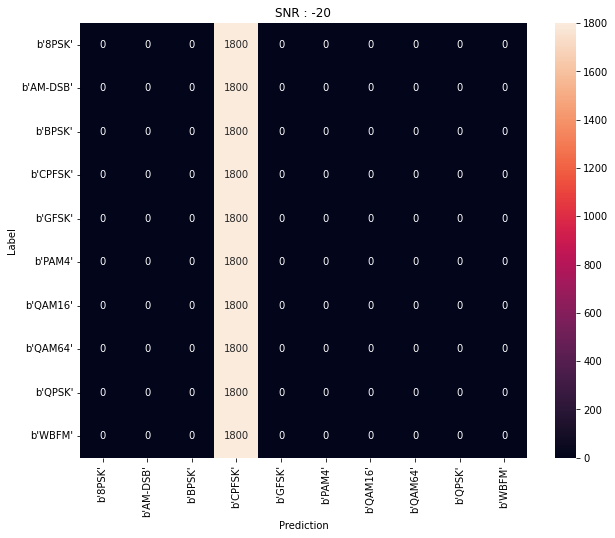

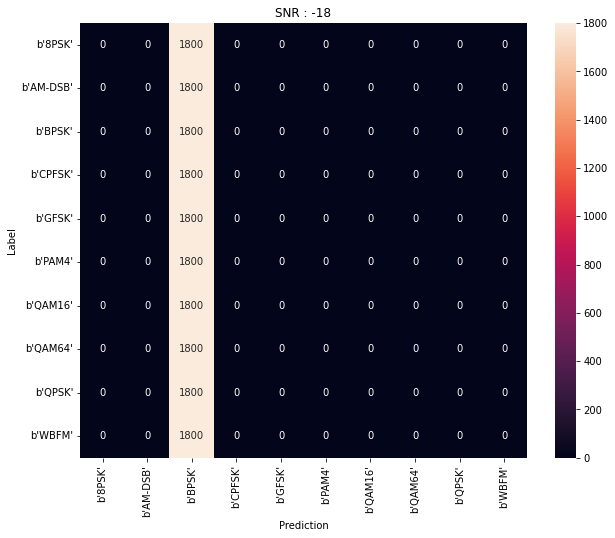

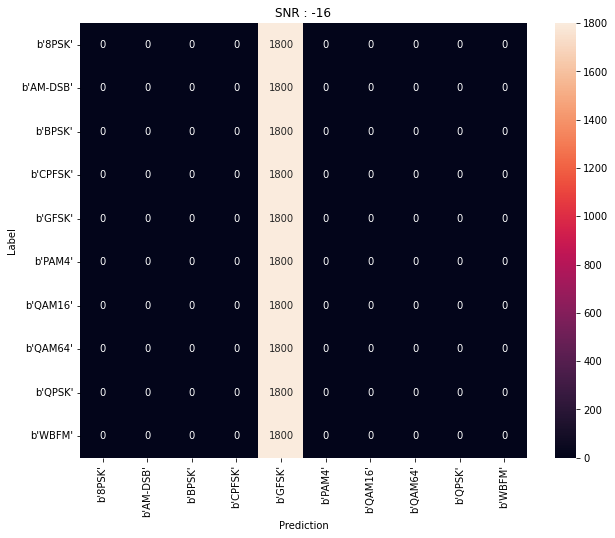

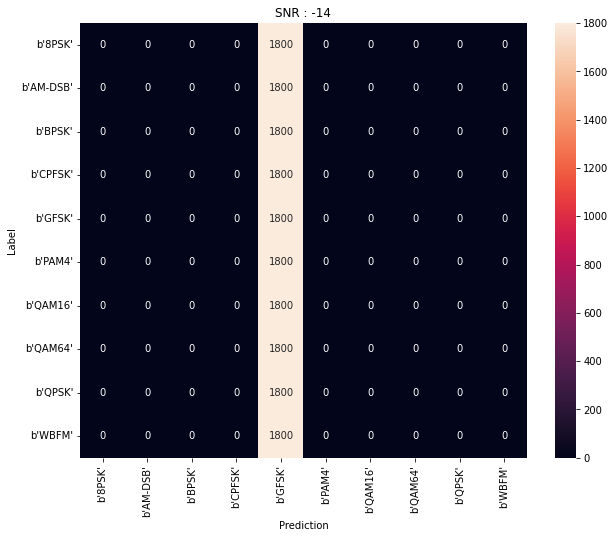

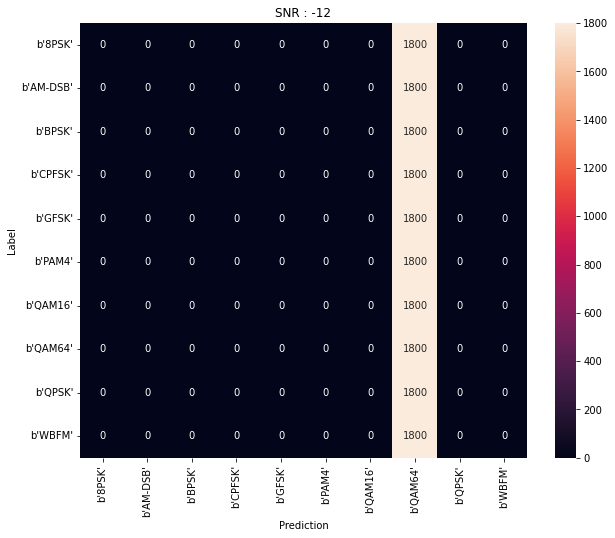

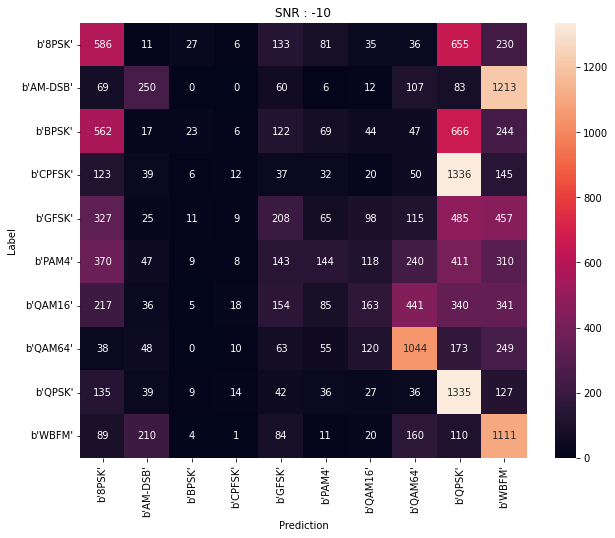

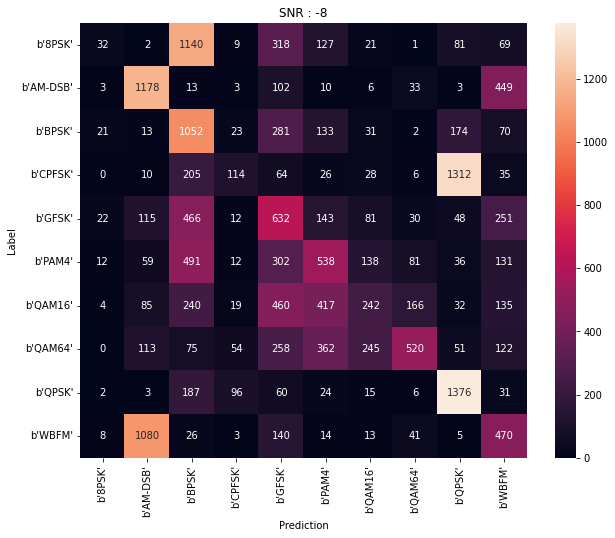

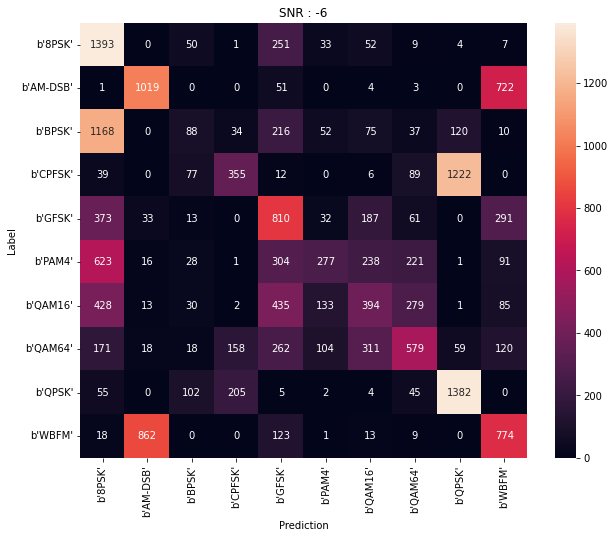

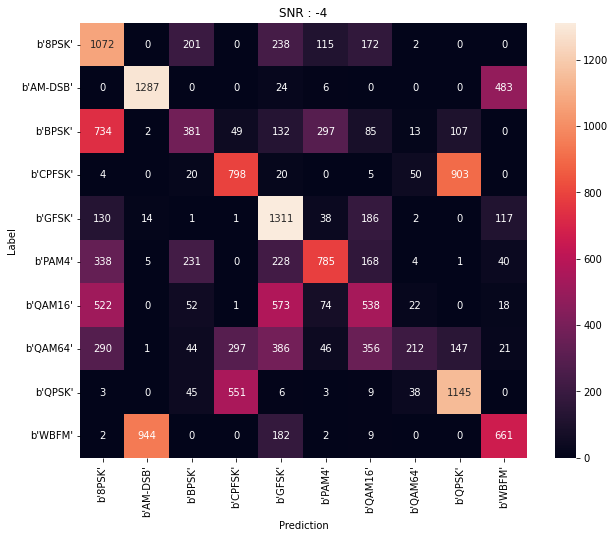

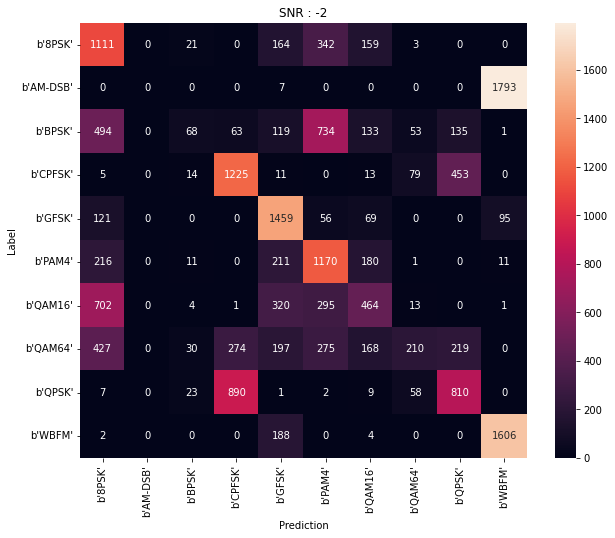

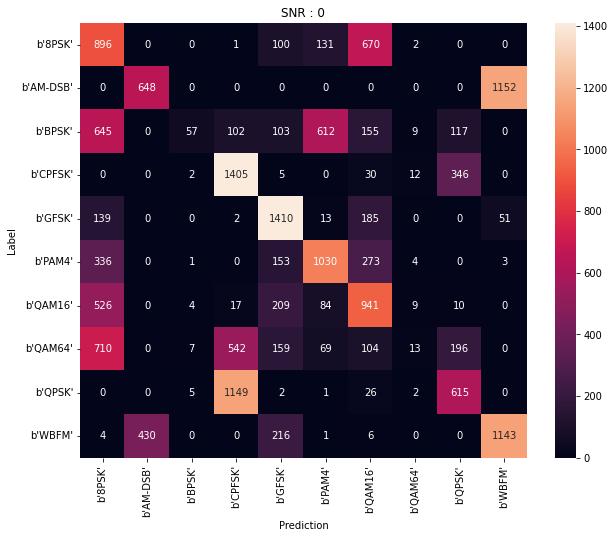

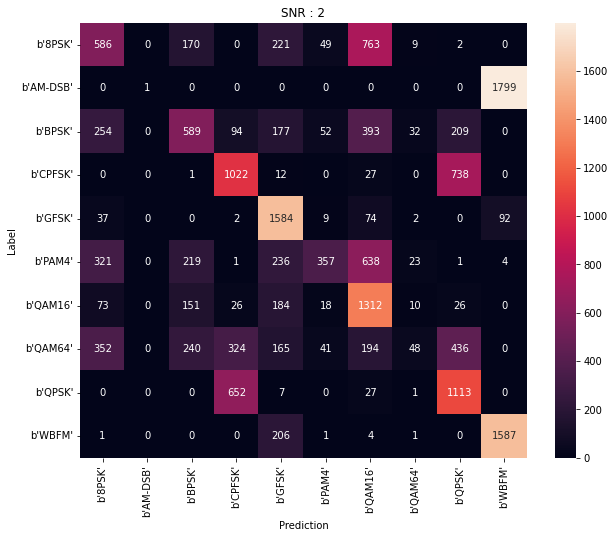

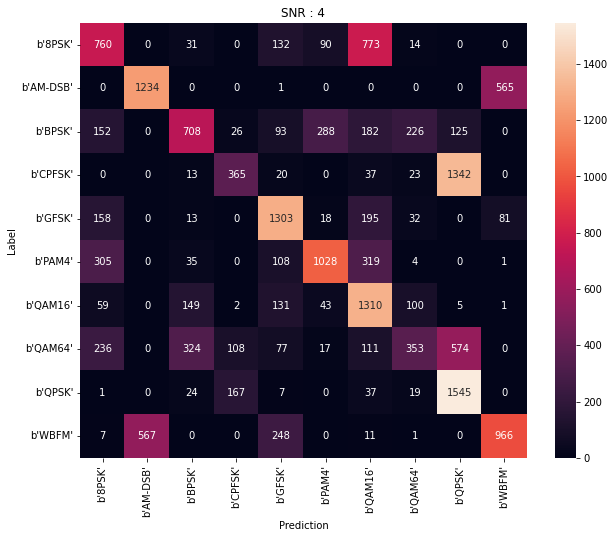

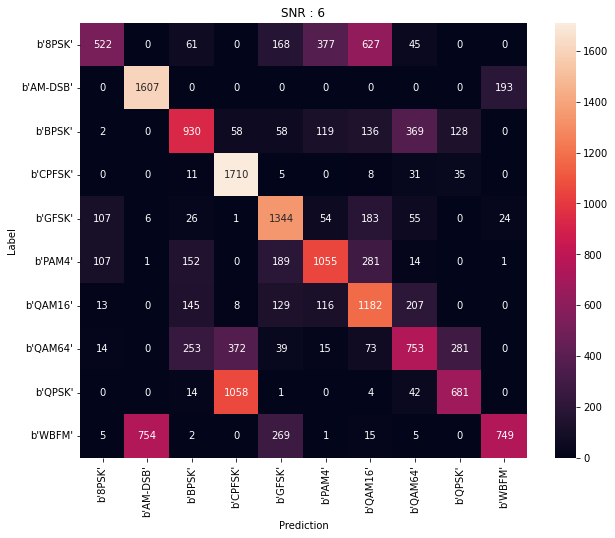

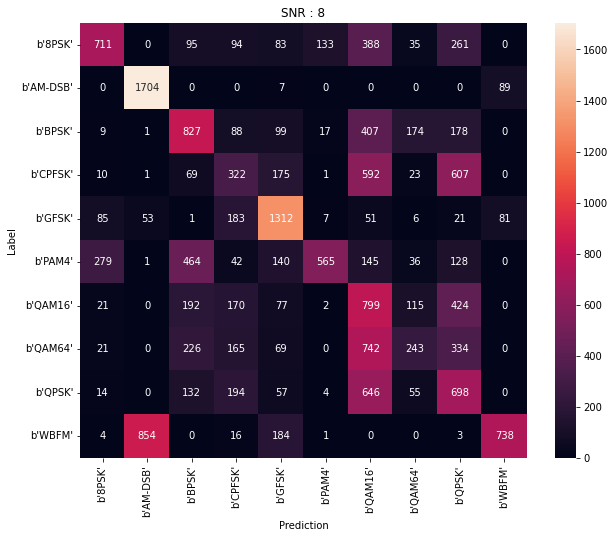

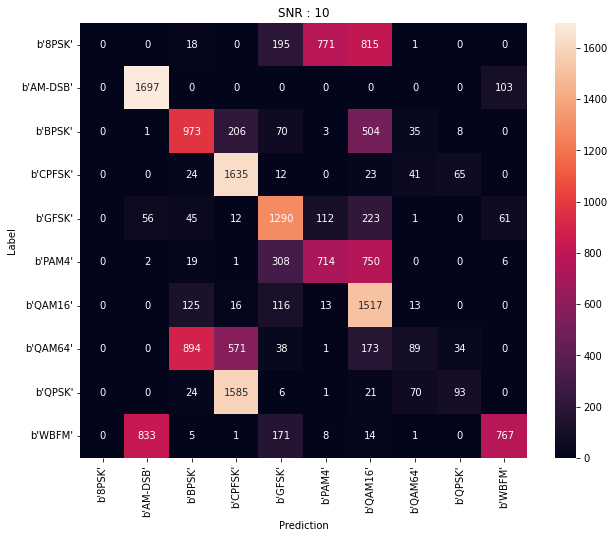

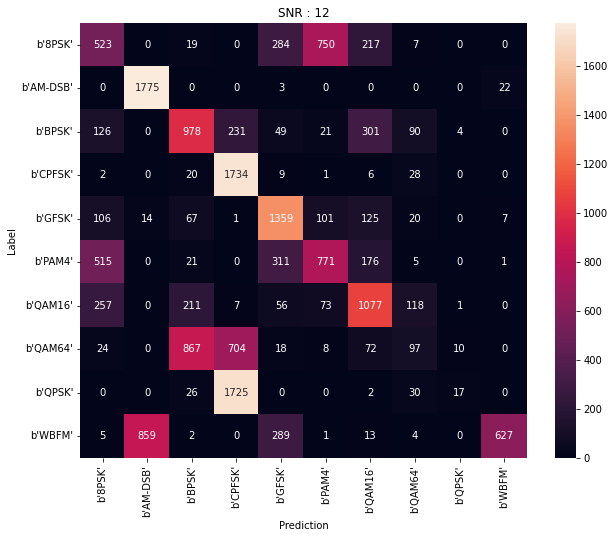

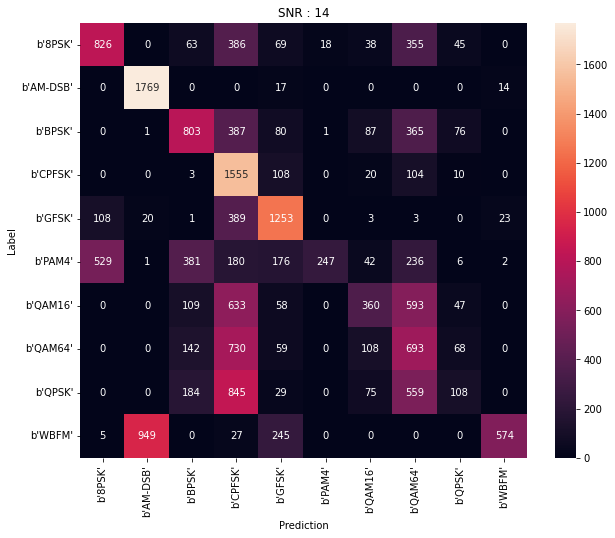

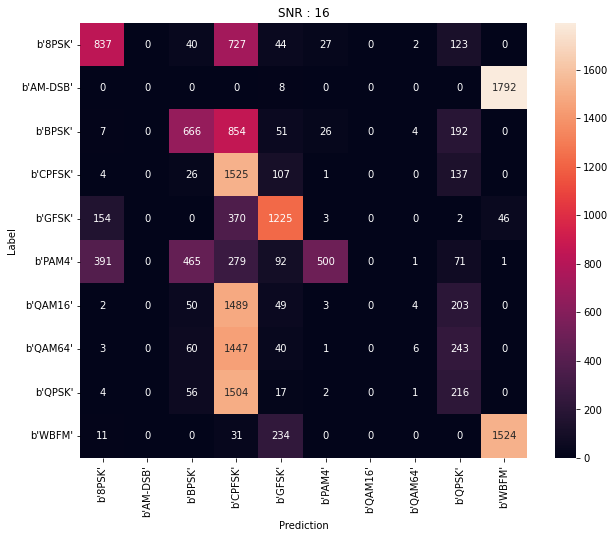

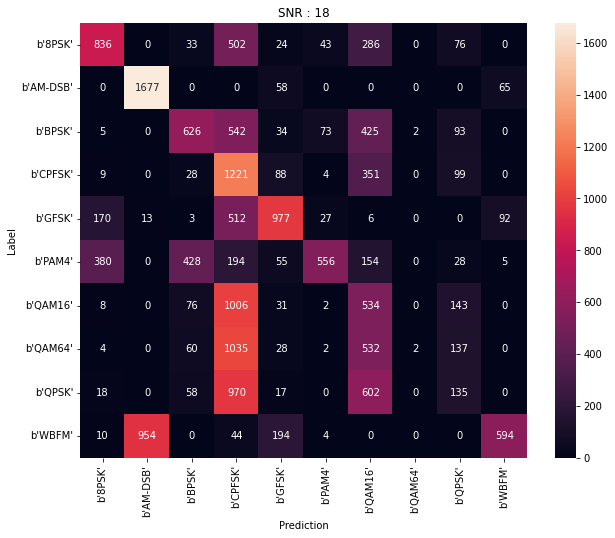

In [31]:
confusion_matrixf(y_preds, lab_test)

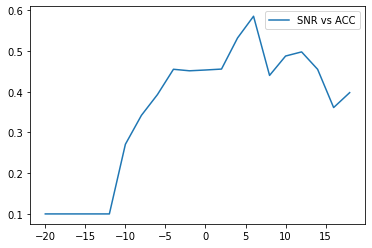

In [32]:
plot_snr_acc(snrs, acc_list)

## RNN

## LSTM 

# 4. Big Picture

# 5. Bonus